 **High-Frequency (Crypto price) trading rules using Machine Learning**
 
 Version 2.0 (Technical Indicators(market data))
 
 Momentum strategy + Meta-Labeling



# Contents

1. Financial Data and Bars 
 - Form Bars
 - Summary and plot


2. Getting Signals (Long position only)
 - Momentum strategy (RSI)


3. Labeling with Triple-Barrier Method
 - Form Symmetric Triple Barrier with the signals
 - Binary Labeling (Profit or Loss)


4. Prediction Model

 4.1. Get Features (X)
 - Market data & Technical Analysis
 - *Market Microstructure Features
 - *Macroeconomic Variables
 - *Fundamentals
 - *News Sentiments with NLP
 
 4.2. Feature Engineering
 - Feature Scaling (MinMaxScaler)
 - Dimension Reduction (PCA/ NL Autoencoder)
 
 4.2. Machine Learning Model
 - Hyperparameter tuning
 - AutoML with *autogluon* and select the best model
 - *Feature Importance
 - Results with PnL
 
 
5. Trading
 - *Bet Sizing
 - *Trading Simulation
 
 
5. Results
 - *Cumulative returns, Sharpe Ratio, Drawdown


In [1]:
# https://www.aidoczh.com/autogluon/install.html
# 安装基础数据科学包
# mamba install -y pandas jupyter ipykernel matplotlib scikit-learn -c conda-forge

# # 使用 pip 安装 macOS 专用的 tensorflow
# pip install tensorflow-macos tensorflow-metal

# python -m pip install tensorflow-macos tensorflow-metal "numpy<2.0" ipykernel matplotlib pandas keras scikit-learn seaborn autogluon ta ta-lib


In [2]:
import numpy
import tensorflow as tf

print(f"Numpy version: {numpy.__version__}")
# 应该显示 1.26.x 或类似版本，绝对不能是 2.x.x

print(f"TensorFlow version: {tf.__version__}")
# 现在应该可以正常输出了

import autogluon as ag




Numpy version: 1.26.4
TensorFlow version: 2.16.2


In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from features import triple_barrier as tb, getTA, tautil
import autogluon as ag

from sklearn import preprocessing
from sklearn.decomposition import PCA 
from features import triple_barrier as tb, getTA, tautil

from scipy.stats import norm, moment

import keras


In [4]:
# De Prado AMFL

# from scipy.stats import norm, moment

# #feature
# from sklearn import preprocessing
# from sklearn.decomposition import PCA 

# #ML
# import autogluon as ag

# deep learning
# import keras

# Technical analysis
# import ta

# Backtesting pyfolio
#import pyfolio as pf


In [5]:
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
def figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(close, linewidth=0.5,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap=cmap, alpha=1)
    plt.colorbar()
    plt.title(title)
    plt.savefig('image/{}.png'.format(title))
    plt.show()

# Financial Data and Bars

## OHLCV Bar + Buy Volume

- Asset: ETH/USD 
- 5 minute data

In [7]:
# df_raw = pd.read_csv('ethusd5min.csv')
# df = df_raw.set_index('timestamp')
# df.index = pd.to_datetime(df.index)

from dataload import data_load_v2

sym = 'ETHUSDT'
data_dir = '/Users/aming/data/ETHUSDT/15m'
start_date_train = '2024-01-01'
end_date_train = '2025-01-01'
start_date_test = '2025-01-01'
end_date_test = '2025-06-01'
timeframe =  '15m'


df = data_load_v2(sym, data_dir=data_dir, start_date=start_date_train, end_date=end_date_test,
                        timeframe=timeframe, file_path=None)

column_mapping = {
    'o':'open',
    'h':'high',
    'l':'low',
    'c':'close',
    'vol':'volume',
    'vol_ccy':'quote_av',
    'trades':'count',
    'close_time':'close_time',
    'taker_buy_volume':'tb_base_av',
    'taker_buy_quote_volume':'tb_quote_av'

}
df = df.rename(columns=column_mapping)



✓ 成功读取 feather: ETHUSDT-15m-2024-01.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2024-02.feather, 行数: 2784
✓ 成功读取 feather: ETHUSDT-15m-2024-03.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2024-04.feather, 行数: 2880
✓ 成功读取 feather: ETHUSDT-15m-2024-05.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2024-06.feather, 行数: 2880
✓ 成功读取 feather: ETHUSDT-15m-2024-07.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2024-08.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2024-09.feather, 行数: 2880
✓ 成功读取 feather: ETHUSDT-15m-2024-10.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2024-11.feather, 行数: 2880
✓ 成功读取 feather: ETHUSDT-15m-2024-12.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2025-01.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2025-02.feather, 行数: 2688
✓ 成功读取 feather: ETHUSDT-15m-2025-03.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2025-04.feather, 行数: 2880
✓ 成功读取 feather: ETHUSDT-15m-2025-05.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2025-06.feather, 行数: 2880

读取完成: 成功 18 个，失败 0 个

合并后总行

In [8]:
df

open     high      low    close     volume  \
open_time                                                            
2024-01-01 00:00:00  2283.84  2299.16  2282.97  2298.49  27345.685   
2024-01-01 00:15:00  2298.50  2298.93  2290.82  2292.83  23160.926   
2024-01-01 00:30:00  2292.83  2296.59  2290.08  2295.19  14889.948   
2024-01-01 00:45:00  2295.20  2299.00  2294.13  2297.41  10196.624   
2024-01-01 01:00:00  2297.41  2299.49  2294.77  2298.53  11625.566   
...                      ...      ...      ...      ...        ...   
2025-06-30 22:45:00  2493.64  2493.65  2487.06  2489.18  18534.150   
2025-06-30 23:00:00  2489.18  2493.66  2486.69  2492.06  16727.303   
2025-06-30 23:15:00  2492.05  2492.17  2487.72  2489.30   9015.189   
2025-06-30 23:30:00  2489.31  2489.89  2485.40  2488.97  12706.276   
2025-06-30 23:45:00  2488.97  2488.97  2483.49  2484.30  29270.039   

                         quote_av  count     close_time  tb_base_av  \
open_time                                                             
2024-01-01 00:00:00  6.267275e+07  28669  1704068099999   16340.943   
2024-01-01 00:15:00  5.316257e+07  21299  1704068999999   10315.998   
2024-01-01 00:30:00  3.414109e+07  14725  1704069899999    8261.921   
2024-01-01 00:45:00  2.342322e+07  10502  1704070799999    5372.395   
2024-01-01 01:00:00  2.670198e+07  10608  1704071699999    6607.579   
...                           ...    ...            ...         ...   
2025-06-30 22:45:00  4.615644e+07  20438  1751324399999    7632.597   
2025-06-30 23:00:00  4.165101e+07  18116  1751325299999    8649.704   
2025-06-30 23:15:00  2.244242e+07  13383  1751326199999    4195.250   
2025-06-30 23:30:00  3.160473e+07  15420  1751327099999    5809.647   
2025-06-30 23:45:00  7.275865e+07  22103  1751327999999   12491.722   

                      tb_quote_av  
open_time                          
2024-01-01 00:00:00  3.745190e+07  
2024-01-01 00:15:00  2.367848e+07  
2024-01-01 00:30:00  1.894291e+07  
2024-01-01 00:45:00  1.234190e+07  
2024-01-01 01:00:00  1.517754e+07  
...                           ...  
2025-06-30 22:45:00  1.900793e+07  
2025-06-30 23:00:00  2.154098e+07  
2025-06-30 23:15:00  1.044394e+07  
2025-06-30 23:30:00  1.445190e+07  
2025-06-30 23:45:00  3.104929e+07  

[52512 rows x 10 columns]

In [9]:
# df

<Axes: xlabel='open_time'>

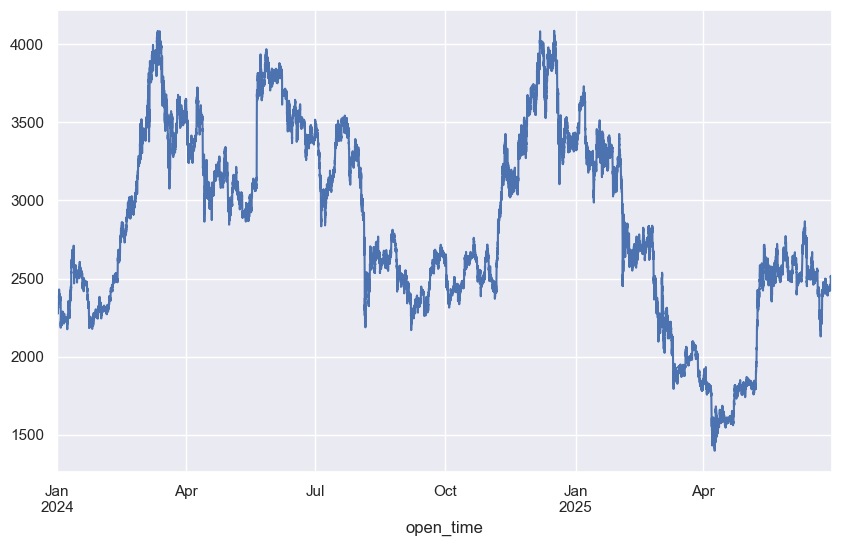

In [10]:
df.close.plot(figsize=(10,6))

In [11]:
# after 2021, there's huge updowns.
# df = df.loc[:'2020-12':,:]

In [12]:
close = pd.to_numeric(df.close)
open = pd.to_numeric(df.open)
high = pd.to_numeric(df.high)
low = pd.to_numeric(df.low)
volume = pd.to_numeric(df.volume)
buy_volume = pd.to_numeric(df.tb_base_av)

## summary & plots

In [13]:
df_ohlcv = pd.DataFrame([open,high,low,close,volume]).T
df_ohlcv.describe()

open          high           low         close        volume
count  52512.000000  52512.000000  52512.000000  52512.000000  5.251200e+04
mean    2841.823123   2848.633775   2834.600943   2841.826964  3.809899e+04
std      599.056799    600.199977    597.721542    599.053994  5.125426e+04
min     1396.800000   1422.190000   1384.000000   1396.810000  0.000000e+00
25%     2442.920000   2448.607500   2437.152500   2442.937500  1.301022e+04
50%     2726.525000   2733.505000   2719.165000   2726.520000  2.287806e+04
75%     3345.632500   3353.162500   3337.002500   3345.627500  4.323308e+04
max     4087.240000   4109.990000   4079.690000   4087.250000  1.290881e+06

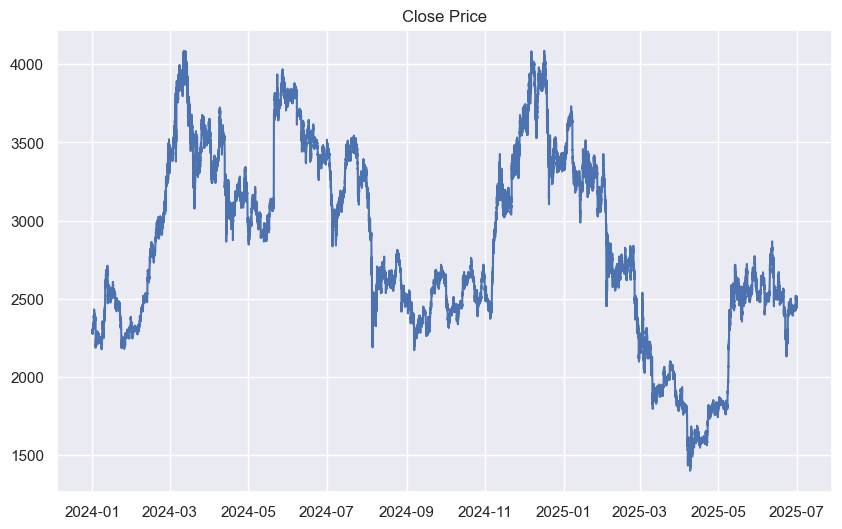

In [14]:
plt.figure(figsize=(10,6))
plt.title('Close Price')
plt.plot(close)
plt.savefig('image/close_price.jpg')
plt.show();

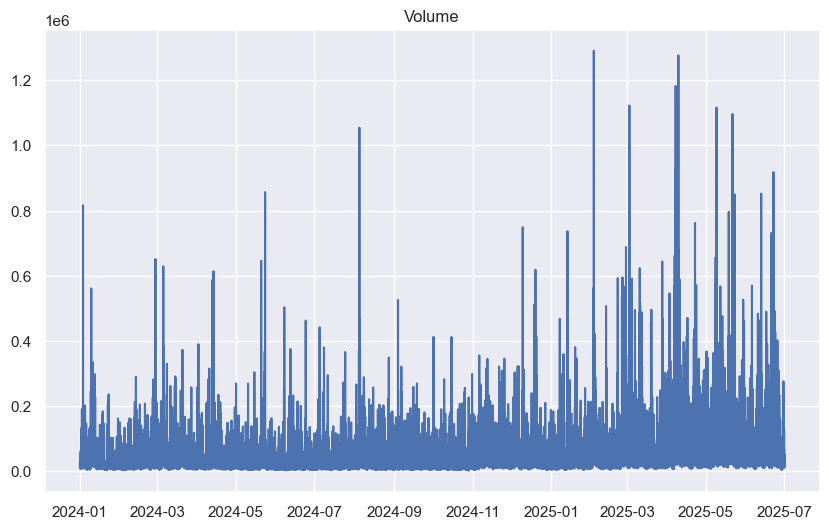

In [15]:
plt.figure(figsize=(10,6))
plt.title('Volume')
plt.plot(volume)
plt.savefig('image/volume.jpg')
plt.show();

In [16]:
of = buy_volume - (volume-buy_volume)

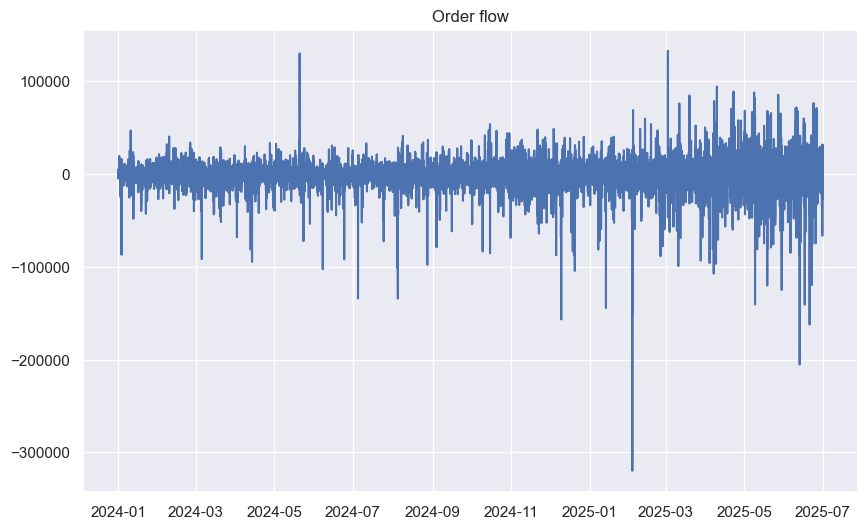

In [17]:
plt.figure(figsize=(10,6))
plt.title('Order flow')
plt.plot(of)
plt.savefig('image/order_flow.jpg')
plt.show();

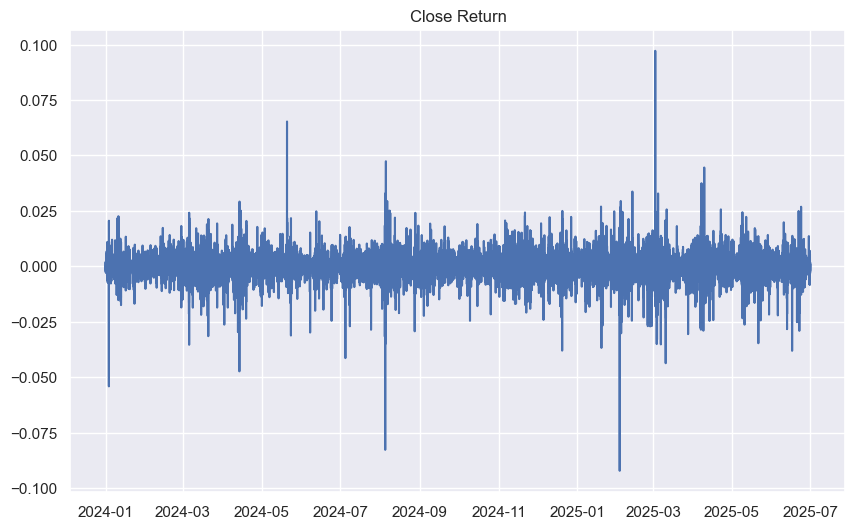

In [18]:
plt.figure(figsize=(10,6))
plt.title('Close Return')
plt.plot(close.pct_change())
plt.savefig('image/closereturn.jpg')
plt.show();

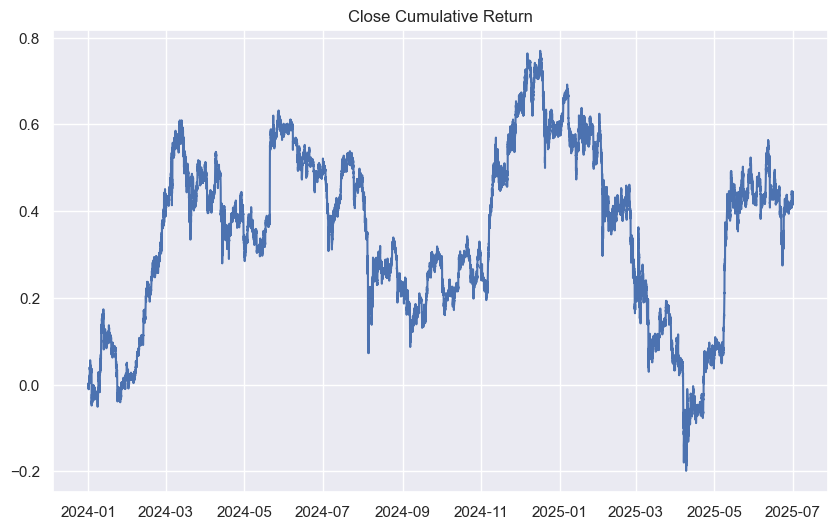

In [19]:
plt.figure(figsize=(10,6))
plt.title('Close Cumulative Return')
plt.plot(np.cumsum(close.pct_change()))
plt.savefig('image/closecumreturn.jpg')
plt.show();

# Getting Signals

 
 I considered only long (up-trend) side.
 
 It is not difficult to do the other side.

## Momentum strategy

In [20]:
windows = np.arange(10,210,10)

For example, let's see the RSI(relative strength index), which is the momentum indicator

I made the threshold to choose when to long or short. 

In [21]:
rsi_df = pd.DataFrame(index=df.index)

In [22]:
# for w in windows:
#     rsi_df['rsi_{}'.format(w)] = tautil.get_rsi(close, w)
rsi_df = tautil.get_my_rsi(close, windows)
rsi_df.dropna(inplace=True)

rsi_df

rsi_10  rsi_20  rsi_30  rsi_40  rsi_50  rsi_60  rsi_70  \
open_time                                                                     
2024-01-03 02:00:00     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-01-03 02:15:00    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
2024-01-03 02:30:00    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
2024-01-03 02:45:00    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
2024-01-03 03:00:00    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-06-30 22:45:00    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
2025-06-30 23:00:00     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2025-06-30 23:15:00    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
2025-06-30 23:30:00    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
2025-06-30 23:45:00    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   

                     rsi_80  rsi_90  rsi_100  rsi_110  rsi_120  rsi_130  \
open_time                                                                 
2024-01-03 02:00:00     1.0     1.0      1.0      1.0      1.0      1.0   
2024-01-03 02:15:00    -1.0    -1.0     -1.0     -1.0     -1.0     -1.0   
2024-01-03 02:30:00    -1.0    -1.0     -1.0     -1.0     -1.0     -1.0   
2024-01-03 02:45:00    -1.0    -1.0     -1.0     -1.0     -1.0     -1.0   
2024-01-03 03:00:00    -1.0    -1.0     -1.0     -1.0     -1.0     -1.0   
...                     ...     ...      ...      ...      ...      ...   
2025-06-30 22:45:00    -1.0    -1.0     -1.0     -1.0     -1.0     -1.0   
2025-06-30 23:00:00     1.0     1.0      1.0      1.0      1.0      1.0   
2025-06-30 23:15:00    -1.0    -1.0     -1.0     -1.0     -1.0     -1.0   
2025-06-30 23:30:00    -1.0    -1.0     -1.0     -1.0     -1.0     -1.0   
2025-06-30 23:45:00    -1.0    -1.0     -1.0     -1.0     -1.0     -1.0   

                     rsi_140  rsi_150  rsi_160  rsi_170  rsi_180  rsi_190  \
open_time                                                                   
2024-01-03 02:00:00      1.0      1.0      1.0      1.0      1.0      1.0   
2024-01-03 02:15:00     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
2024-01-03 02:30:00     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
2024-01-03 02:45:00     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
2024-01-03 03:00:00     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...                      ...      ...      ...      ...      ...      ...   
2025-06-30 22:45:00     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
2025-06-30 23:00:00      1.0      1.0      1.0      1.0      1.0      1.0   
2025-06-30 23:15:00     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
2025-06-30 23:30:00     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
2025-06-30 23:45:00     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

                     rsi_200  
open_time                     
2024-01-03 02:00:00      1.0  
2024-01-03 02:15:00     -1.0  
2024-01-03 02:30:00     -1.0  
2024-01-03 02:45:00     -1.0  
2024-01-03 03:00:00     -1.0  
...                      ...  
2025-06-30 22:45:00     -1.0  
2025-06-30 23:00:00      1.0  
2025-06-30 23:15:00     -1.0  
2025-06-30 23:30:00     -1.0  
2025-06-30 23:45:00     -1.0  

[52312 rows x 20 columns]

rsi(14) is often adopted in daily data.

Here is 5 minutes data.

And we have to consider this is crypto data which is far more volatile.


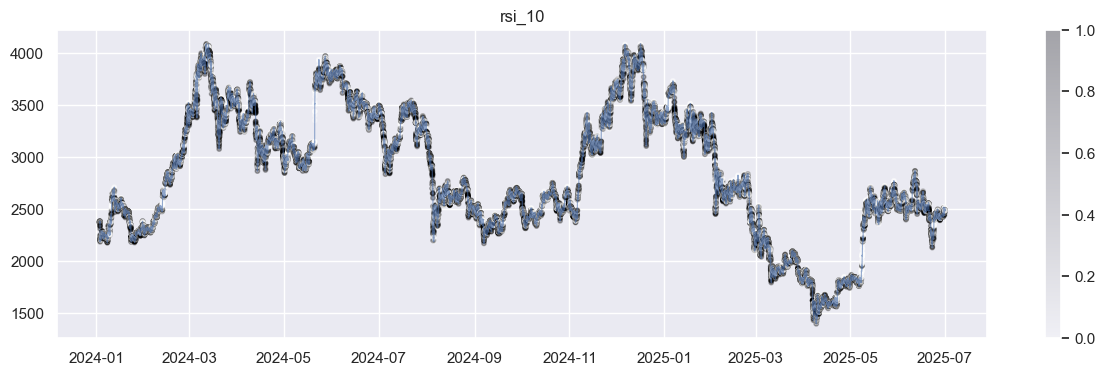

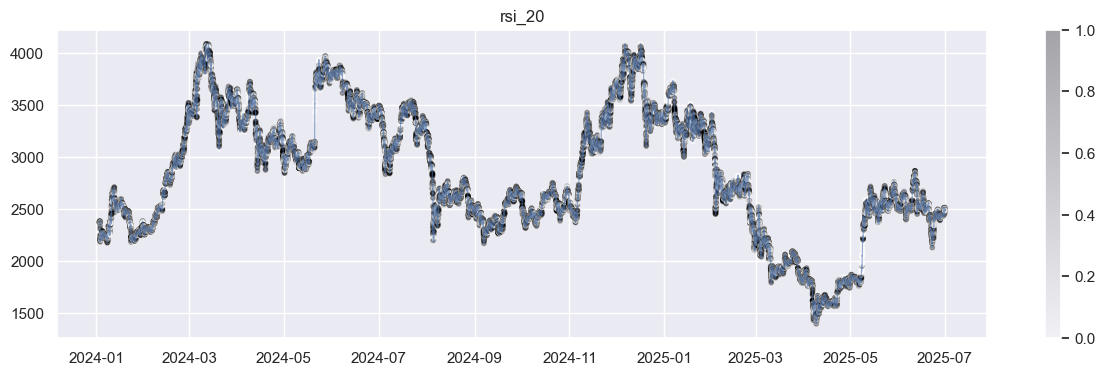

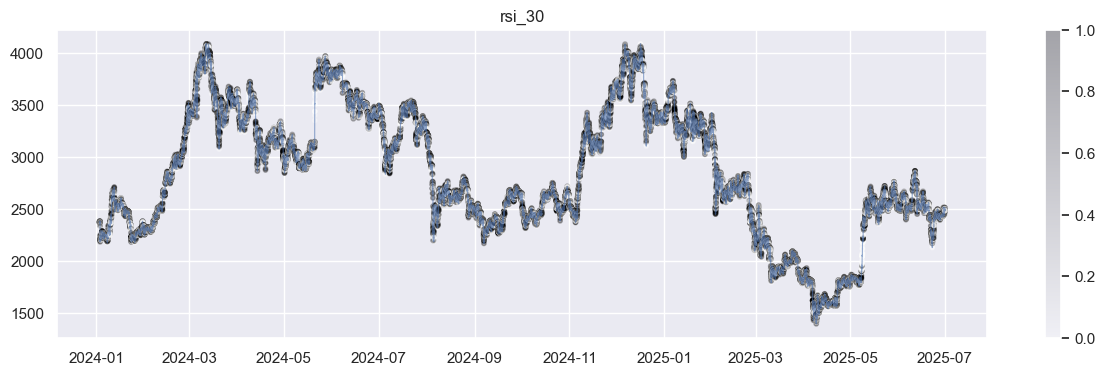

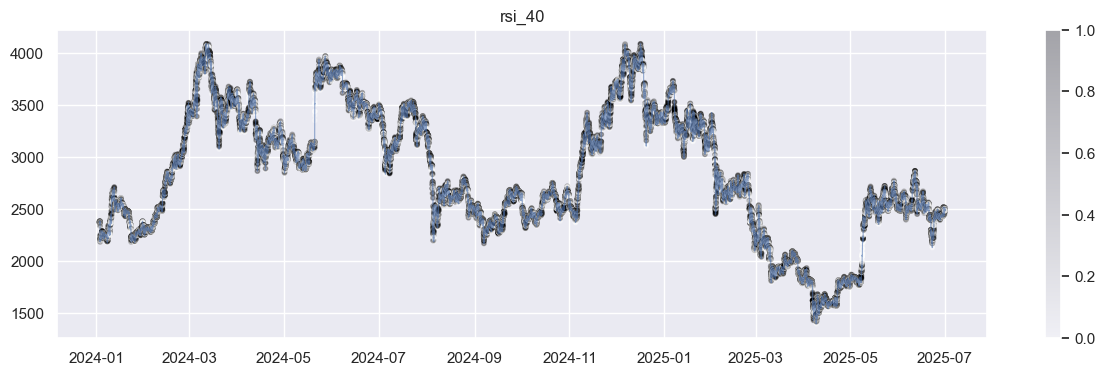

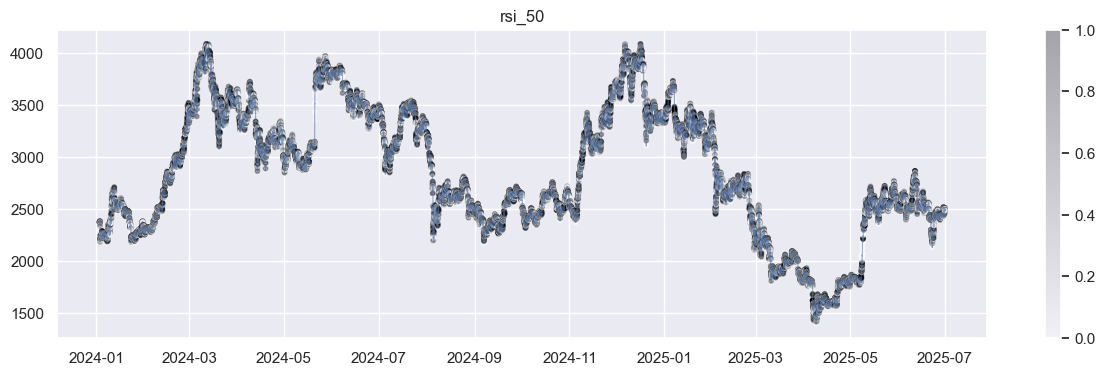

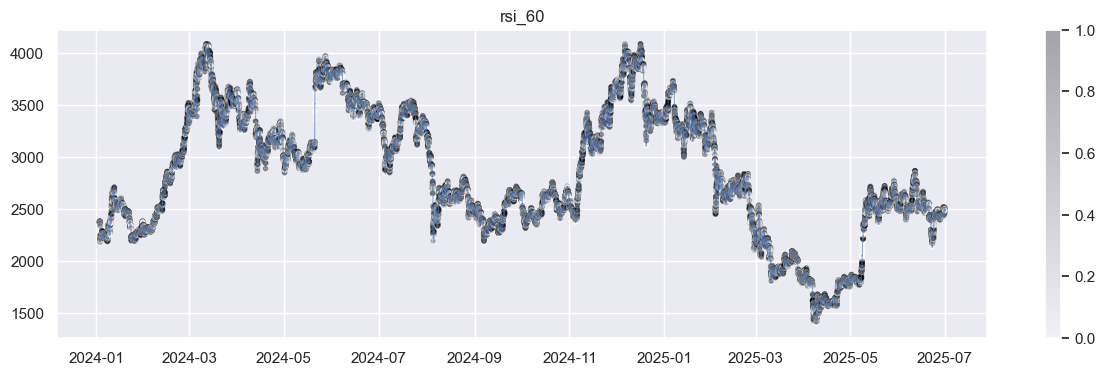

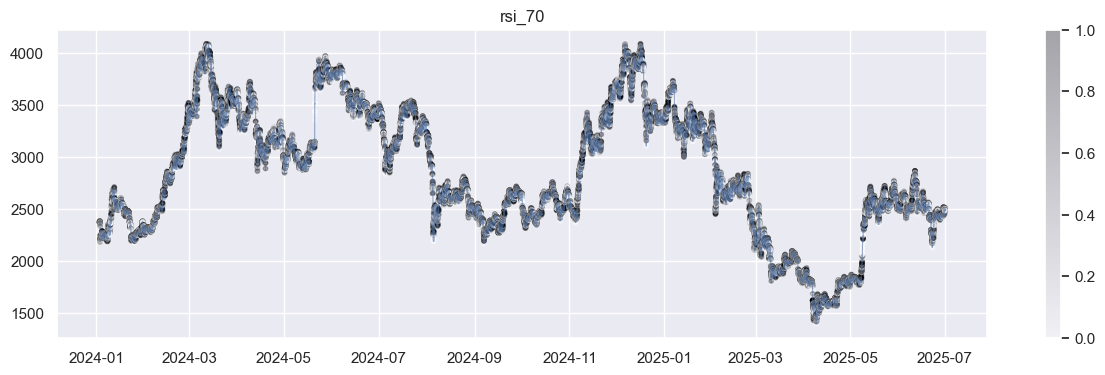

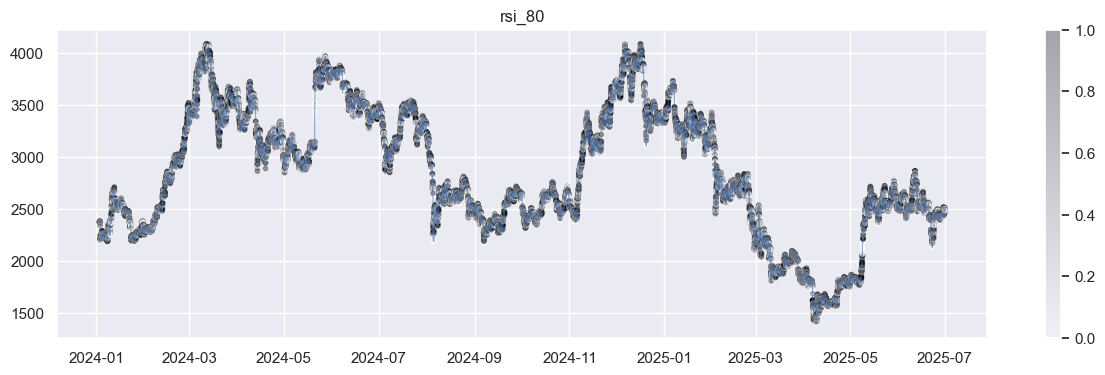

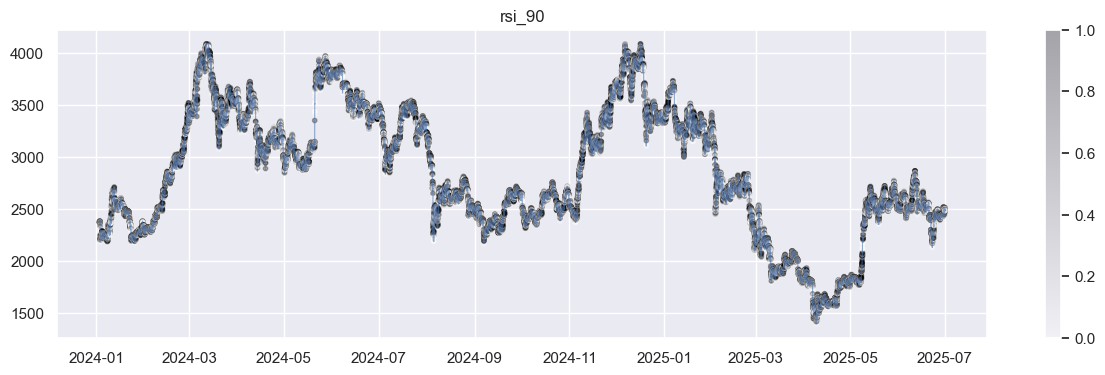

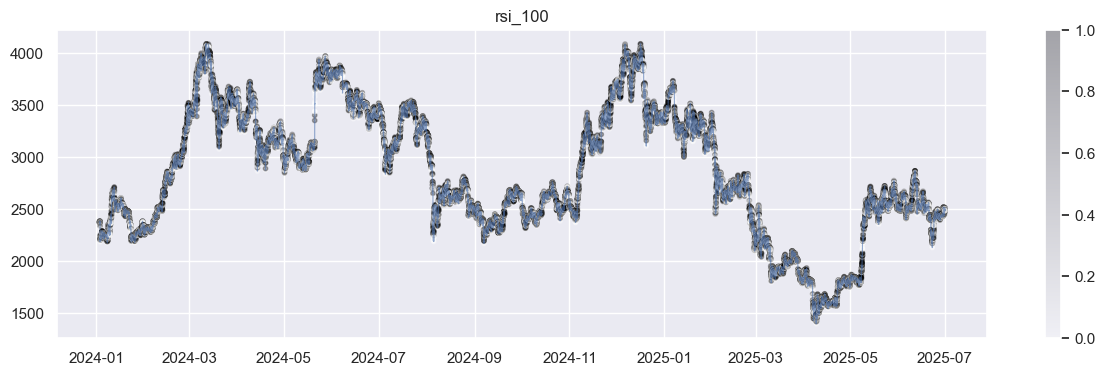

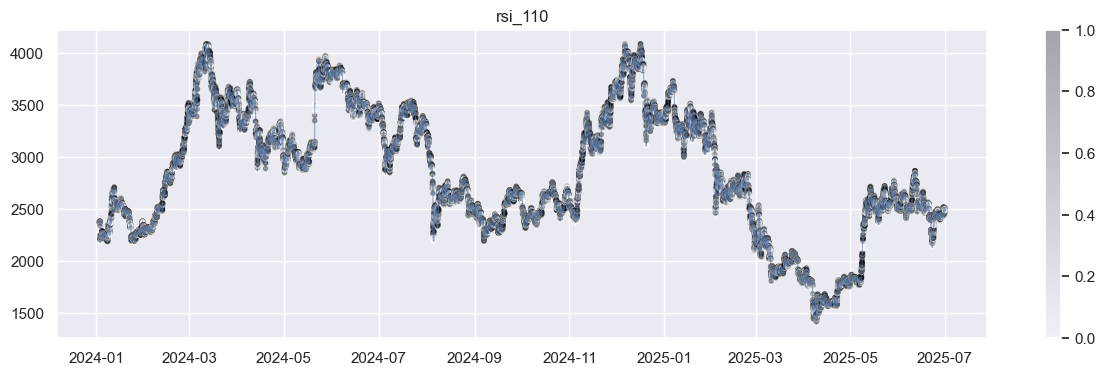

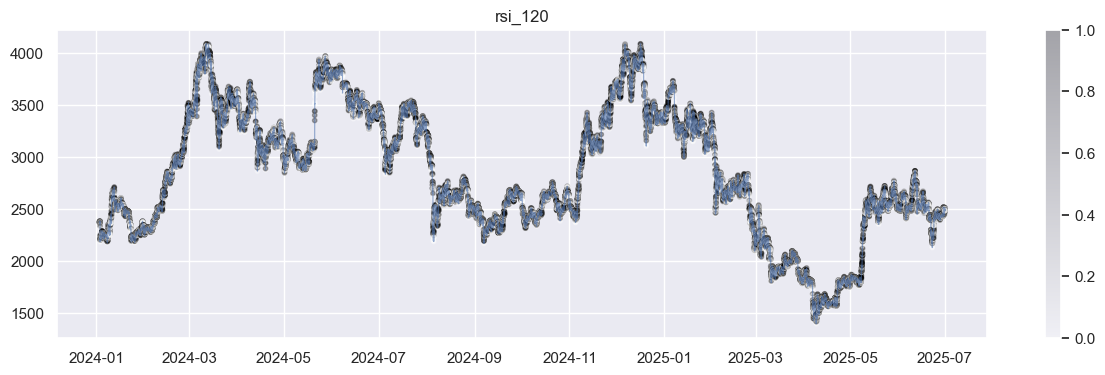

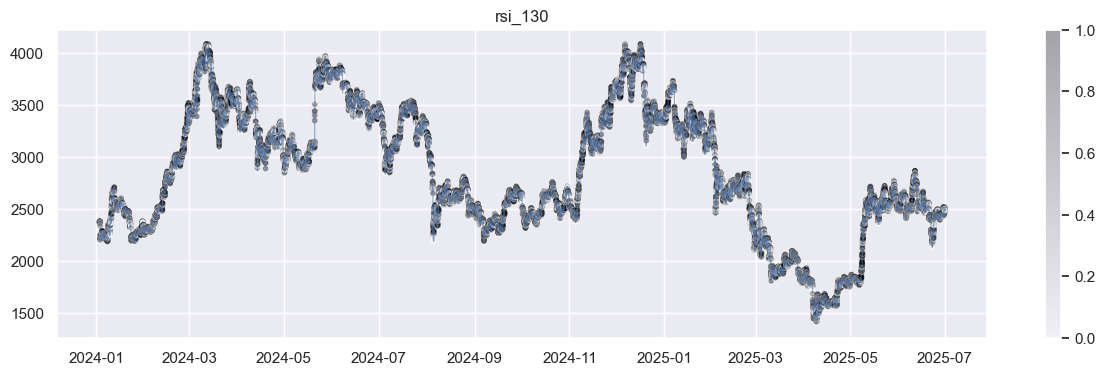

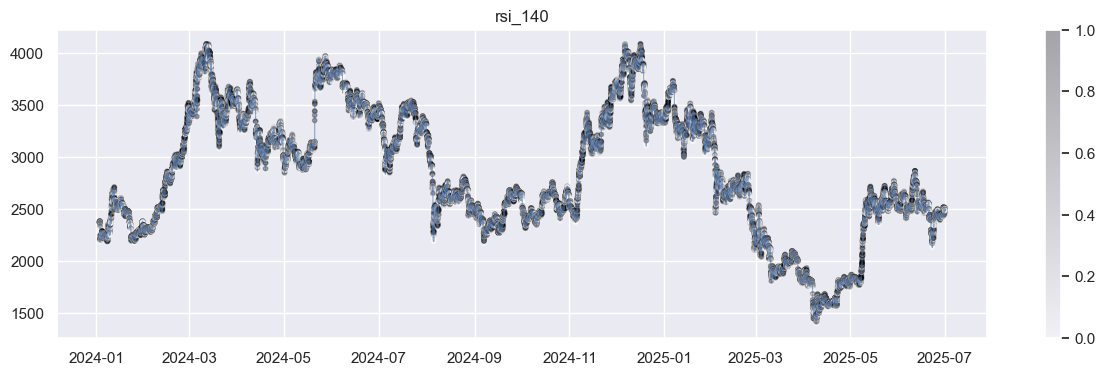

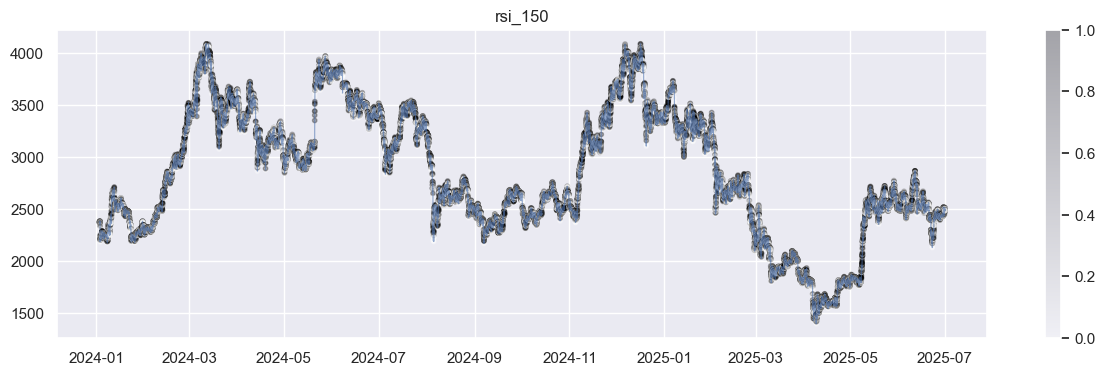

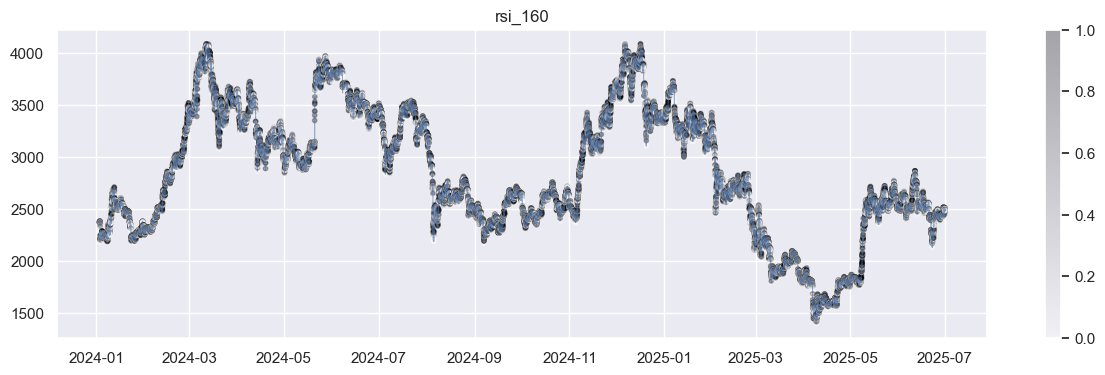

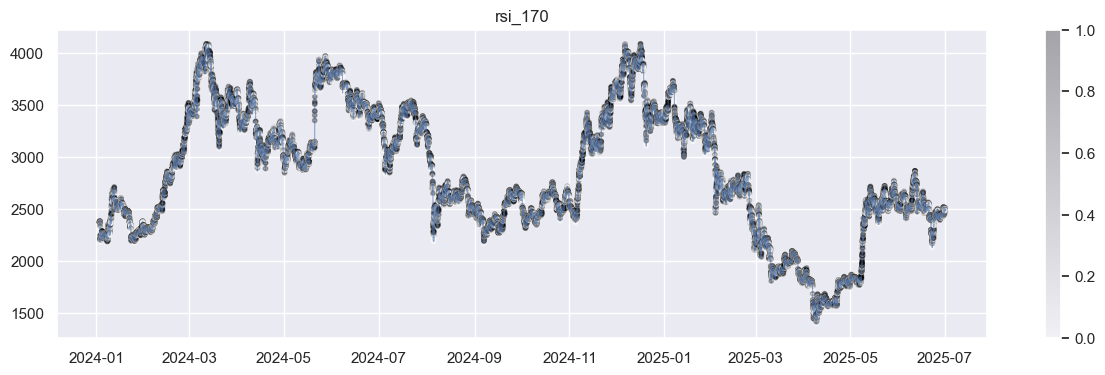

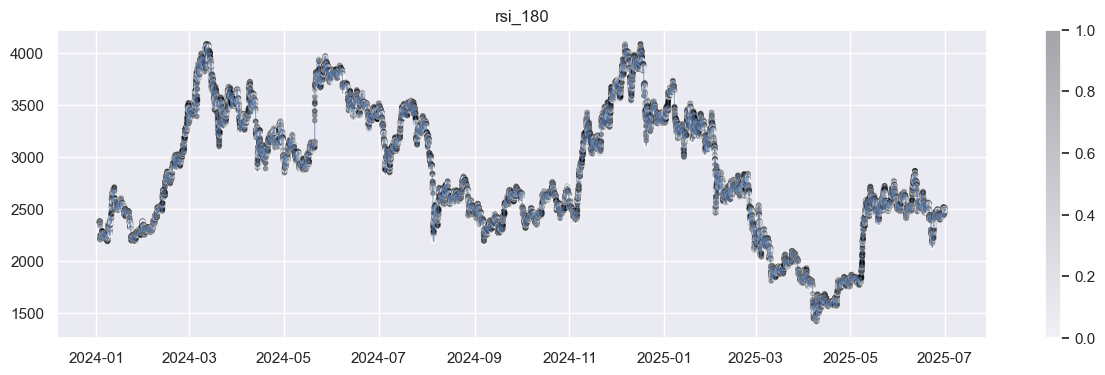

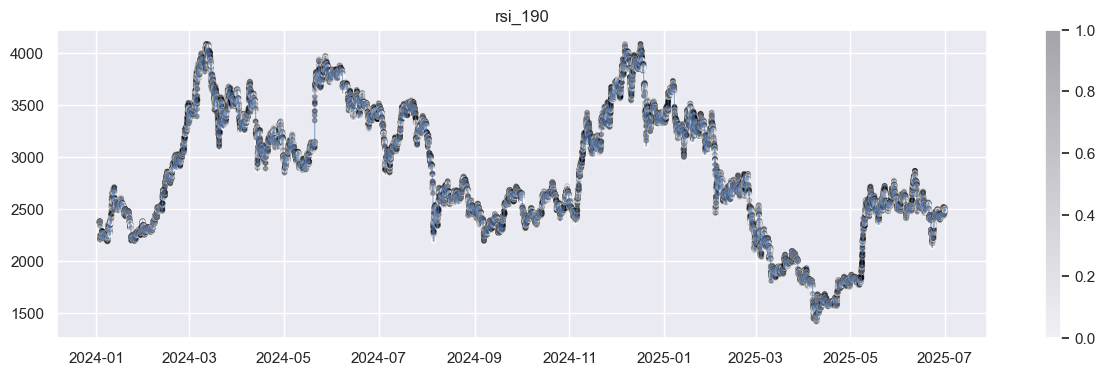

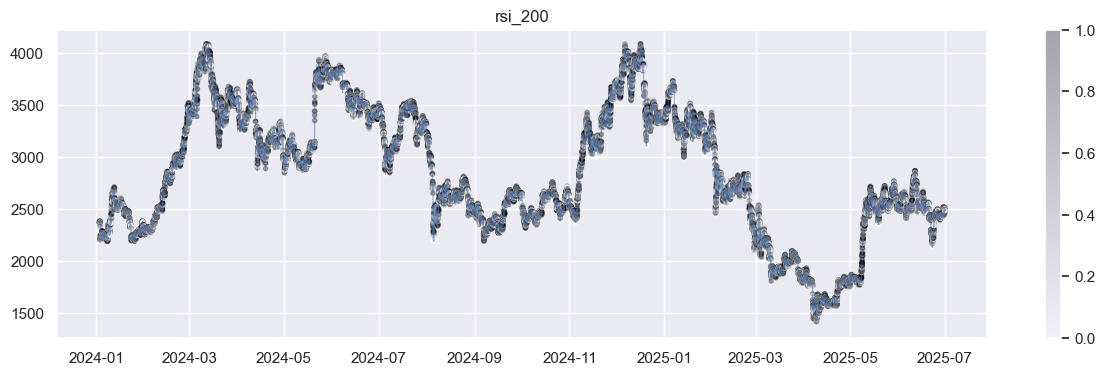

In [23]:
# long signals

for i in rsi_df.columns:
    sc = rsi_df[i].copy()
    plt.figure(figsize=(15,4))
    plt.plot(close.loc[sc.index], linewidth=0.8,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap='gray_r', s = 10, alpha=0.3, vmin=0,vmax=1)
    plt.colorbar()
    plt.title('{}'.format(i))
    plt.show()

# Labeling with Triple-Barrier Method
 ## Form Symmetric Triple Barrier with signals
 

Below is for testing various windows.

In [24]:
# returns_df = pd.DataFrame()

# for rsi_w in rsi_df.columns:
#    long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
#    enter = long.index
#    pt_sl = [0.05,0.05] # profit-taking, stop-loss target
#    max_holding = [3,0] #[day,hours]
#    barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)
#    returns_df['ret_{}'.format(rsi_w)] = barrier.ret

In [25]:
# for r in returns_df.columns:
#    ret = returns_df[r].dropna()
#    # Intended symmetric returns
#    plt.figure(figsize=(10,6))
#    plt.title('Symmetric returns of Primary Model')
#    plt.bar(ret.index, ret.dropna(),linewidth=0)
#    #plt.savefig('return_of_1stmodel.jpg')
#    plt.show();

In [26]:
#returns_df.cumsum()

For simplicity, I will choose rsi window = 100 for this asset and interval.

You can use other methods, for example combining with MACD.


In [27]:
rsi_w = 'rsi_100'

# rsi_df[rsi_df[rsi_w]!=1]
long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
enter = long.index
pt_sl = [0.05,0.05] # profit-taking, stop-loss target
max_holding = [14,0] #[day,hours]
enter

barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)
barrier

exit    price       ret  side
open_time                                                       
2024-01-03 02:00:00 2024-01-03 12:00:00  2380.27 -0.085671   1.0
2024-01-03 03:15:00 2024-01-03 12:00:00  2369.88 -0.081297   1.0
2024-01-03 03:45:00 2024-01-03 12:00:00  2370.36 -0.081499   1.0
2024-01-03 04:00:00 2024-01-03 12:00:00  2371.15 -0.081832   1.0
2024-01-03 04:15:00 2024-01-03 12:00:00  2373.38 -0.082773   1.0
...                                 ...      ...       ...   ...
2025-06-30 20:15:00                 NaT  2512.48  0.000000   1.0
2025-06-30 21:30:00                 NaT  2494.61  0.000000   1.0
2025-06-30 22:15:00                 NaT  2489.51  0.000000   1.0
2025-06-30 22:30:00                 NaT  2493.65  0.000000   1.0
2025-06-30 23:00:00                 NaT  2492.06  0.000000   1.0

[26331 rows x 4 columns]

Make triple barrier using long signals, profit-taking/stop-loss target returns (must be symmetric), and maximum holding period.

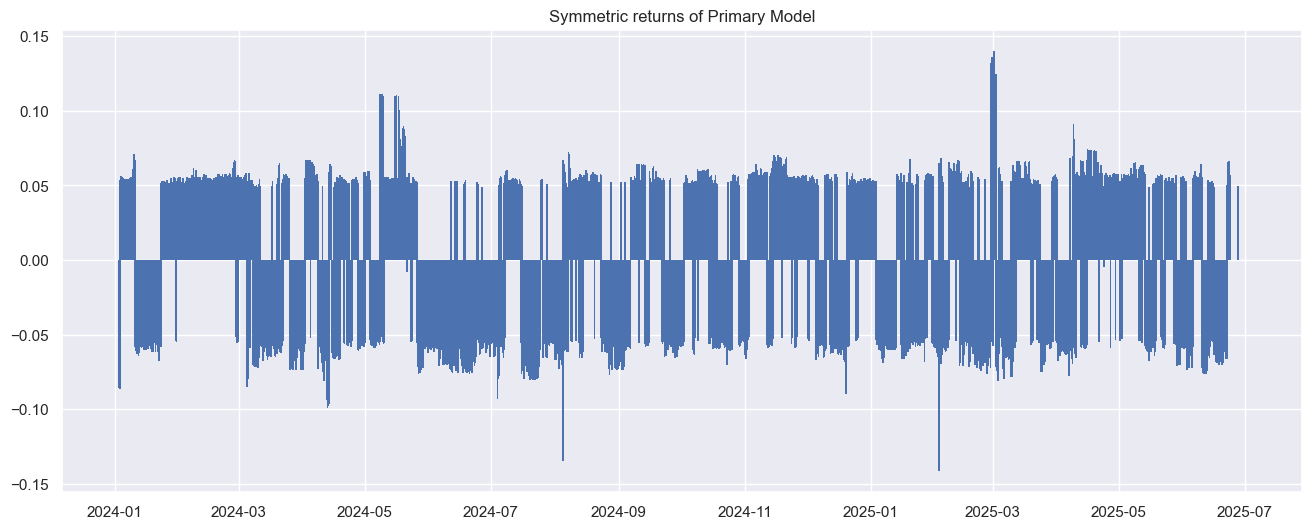

In [28]:
ret = barrier.ret
plt.figure(figsize=(16,6))
plt.title('Symmetric returns of Primary Model')
plt.bar(ret.index, ret.dropna(),linewidth=0)
plt.savefig('image/returns_of_1stmodel.jpg')
plt.show();

You can see the symmetric returns, except for those who exceed max holding periods. 

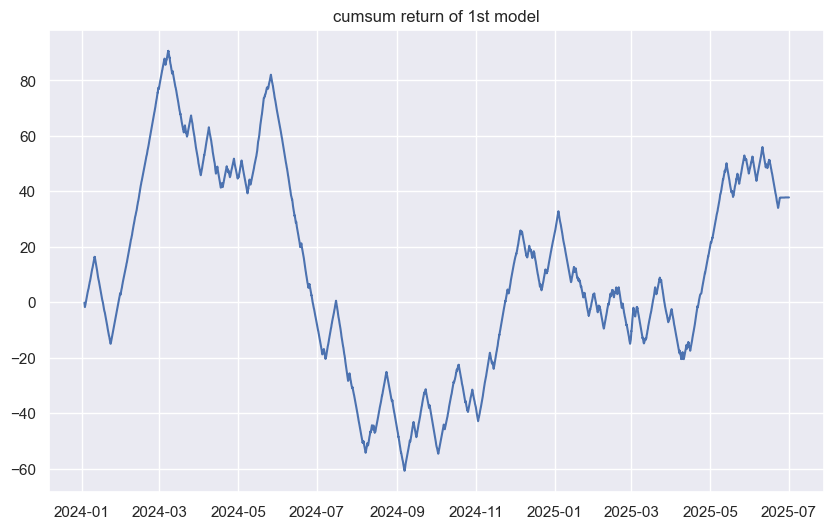

In [29]:
plt.figure(figsize=(10,6))
plt.title('cumsum return of 1st model')
plt.savefig('image/cumsum_return_1stmodel.jpg')
plt.plot(ret.cumsum())
plt.show()

## Binary Labeling (Profit or Loss)

In [30]:
first_model = pd.DataFrame()
first_model['y_pred'] = long
first_model['y_true'] = np.sign(long*barrier.ret)
first_model = first_model.dropna()

y_pred1 = first_model.y_pred
y_true1 = first_model.y_true

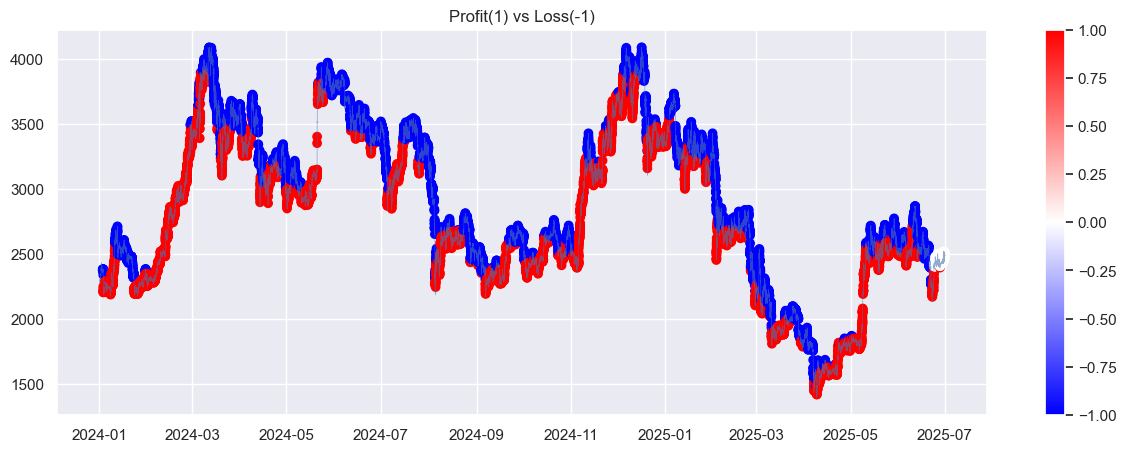

In [31]:
sc = y_true1
title = 'Profit(1) vs Loss(-1)'
figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5))

In [32]:
pnllabel = y_true1.loc[y_true1!=0]
pnllabel.value_counts()

y_true
 1.0    13805
-1.0    12179
Name: count, dtype: int64

In [33]:
print('Probability of winning: ',pnllabel.value_counts().values[0] / pnllabel.value_counts().values.sum())

Probability of winning:  0.5312884852216748


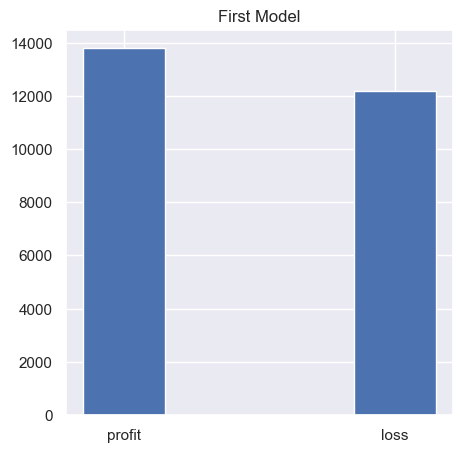

In [34]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],pnllabel.value_counts(), width=0.3)
plt.title('First Model')
plt.savefig('image/pnl_first_model.jpg')
plt.show()

# Prediction Model

For feature engineering we have to split train and test periods.

In [35]:
y = pnllabel.copy().rename('y').to_frame()
train_y = y.loc[:end_date_train,:]
test_y = y.loc[start_date_test:,:]
y
train_y

y
open_time               
2024-01-03 02:00:00 -1.0
2024-01-03 03:15:00 -1.0
2024-01-03 03:45:00 -1.0
2024-01-03 04:00:00 -1.0
2024-01-03 04:15:00 -1.0
...                  ...
2025-01-01 22:15:00  1.0
2025-01-01 22:30:00  1.0
2025-01-01 23:00:00  1.0
2025-01-01 23:30:00  1.0
2025-01-01 23:45:00  1.0

[17624 rows x 1 columns]

 ## Get Features (X)
 
 ###  Market data

Market
- Techincal indicators with market data


In [36]:
df_ = df_ohlcv

In [37]:
mts= [5,10,30,60,100] #multipliers
TA = getTA.get_ta_windows(df_,mts)

In [38]:
TA

aroon_125  aroon_1500  aroon_250  aroon_2500  aroon_750  \
open_time                                                                      
2024-01-01 00:00:00        NaN         NaN        NaN         NaN        NaN   
2024-01-01 00:15:00        NaN         NaN        NaN         NaN        NaN   
2024-01-01 00:30:00        NaN         NaN        NaN         NaN        NaN   
2024-01-01 00:45:00        NaN         NaN        NaN         NaN        NaN   
2024-01-01 01:00:00        NaN         NaN        NaN         NaN        NaN   
...                        ...         ...        ...         ...        ...   
2025-06-30 22:45:00        6.4  -38.266667        3.2       -43.0  80.266667   
2025-06-30 23:00:00        6.4  -38.266667        3.2       -43.0  80.266667   
2025-06-30 23:15:00        6.4  -38.266667        3.2       -43.0  80.266667   
2025-06-30 23:30:00        6.4  -38.266667        3.2       -43.0  80.266667   
2025-06-30 23:45:00        6.4  -38.266667        3.2       -43.0  80.266667   

                     dpo_100   dpo_1200   dpo_200   dpo_2000    dpo_600  ...  \
open_time                                                                ...   
2024-01-01 00:00:00      NaN        NaN       NaN        NaN        NaN  ...   
2024-01-01 00:15:00      NaN        NaN       NaN        NaN        NaN  ...   
2024-01-01 00:30:00      NaN        NaN       NaN        NaN        NaN  ...   
2024-01-01 00:45:00      NaN        NaN       NaN        NaN        NaN  ...   
2024-01-01 01:00:00      NaN        NaN       NaN        NaN        NaN  ...   
...                      ...        ...       ...        ...        ...  ...   
2025-06-30 22:45:00 -35.7127  48.415950 -25.70195  52.091395 -35.050767  ...   
2025-06-30 23:00:00 -32.7365  56.706733 -30.98655  50.305680 -31.496033  ...   
2025-06-30 23:15:00 -29.0095  37.759792 -16.75180  54.341330 -25.755333  ...   
2025-06-30 23:30:00 -29.5497  26.597983  16.28280  53.667890 -21.911750  ...   
2025-06-30 23:45:00 -25.6427  34.021558  29.98875  47.779870 -19.718100  ...   

                       rsi_140   rsi_1400    rsi_420     rsi_70    rsi_840  \
open_time                                                                    
2024-01-01 00:00:00        NaN        NaN        NaN        NaN        NaN   
2024-01-01 00:15:00        NaN        NaN        NaN        NaN        NaN   
2024-01-01 00:30:00        NaN        NaN        NaN        NaN        NaN   
2024-01-01 00:45:00        NaN        NaN        NaN        NaN        NaN   
2024-01-01 01:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2025-06-30 22:45:00  52.579301  50.135413  51.178747  52.680947  50.314046   
2025-06-30 23:00:00  52.805108  50.153485  51.248029  53.093892  50.345636   
2025-06-30 23:15:00  52.563515  50.136060  51.178262  52.647212  50.314942   
2025-06-30 23:30:00  52.534571  50.133976  51.169913  52.593541  50.311271   
2025-06-30 23:45:00  52.125448  50.104480  51.051775  51.834897  50.259304   

                     stoch_diff_1400_3  stoch_diff_140_3  stoch_diff_420_3  \
open_time                                                                    
2024-01-01 00:00:00                NaN               NaN               NaN   
2024-01-01 00:15:00                NaN               NaN               NaN   
2024-01-01 00:30:00                NaN               NaN               NaN   
2024-01-01 00:45:00                NaN               NaN               NaN   
2024-01-01 01:00:00                NaN               NaN               NaN   
...                                ...               ...               ...   
2025-06-30 22:45:00          -0.281195         -1.356392         -1.085408   
2025-06-30 23:00:00           0.075571          0.364530          0.291703   
2025-06-30 23:15:00          -0.154657         -0.746016         -0.596974   
2025-06-30 23:30:00          -0.200351         -0.966429         -

First I chose default windows (daily) for each technical indicators/

This is 5 minute data and in first model, I chose rsi_100 instead of rsi_14.

So I will muliply some numbers to the windows. [10,30,50,100]

In [39]:
mkt = TA.copy()

for i in [1,5,10,30]:
    mkt = mkt.join(volume.diff(i).rename('vol_mom_{}'.format(i)))
    mkt = mkt.join(of.diff(i).rename('of_mom_{}'.format(i)))
    mkt = mkt.join(close.diff(i).rename('mom_{}'.format(i)))
    
for i in [5,30,60,100]:
    mkt = mkt.join(close.rolling(i).std().rename('std_{}'.format(i)))
    mkt = mkt.join(volume.rolling(i).std().rename('vol_std_{}'.format(i)))
                   

corr = mkt.corr()
#corr.style.background_gradient(cmap='coolwarm').set_precision(2)

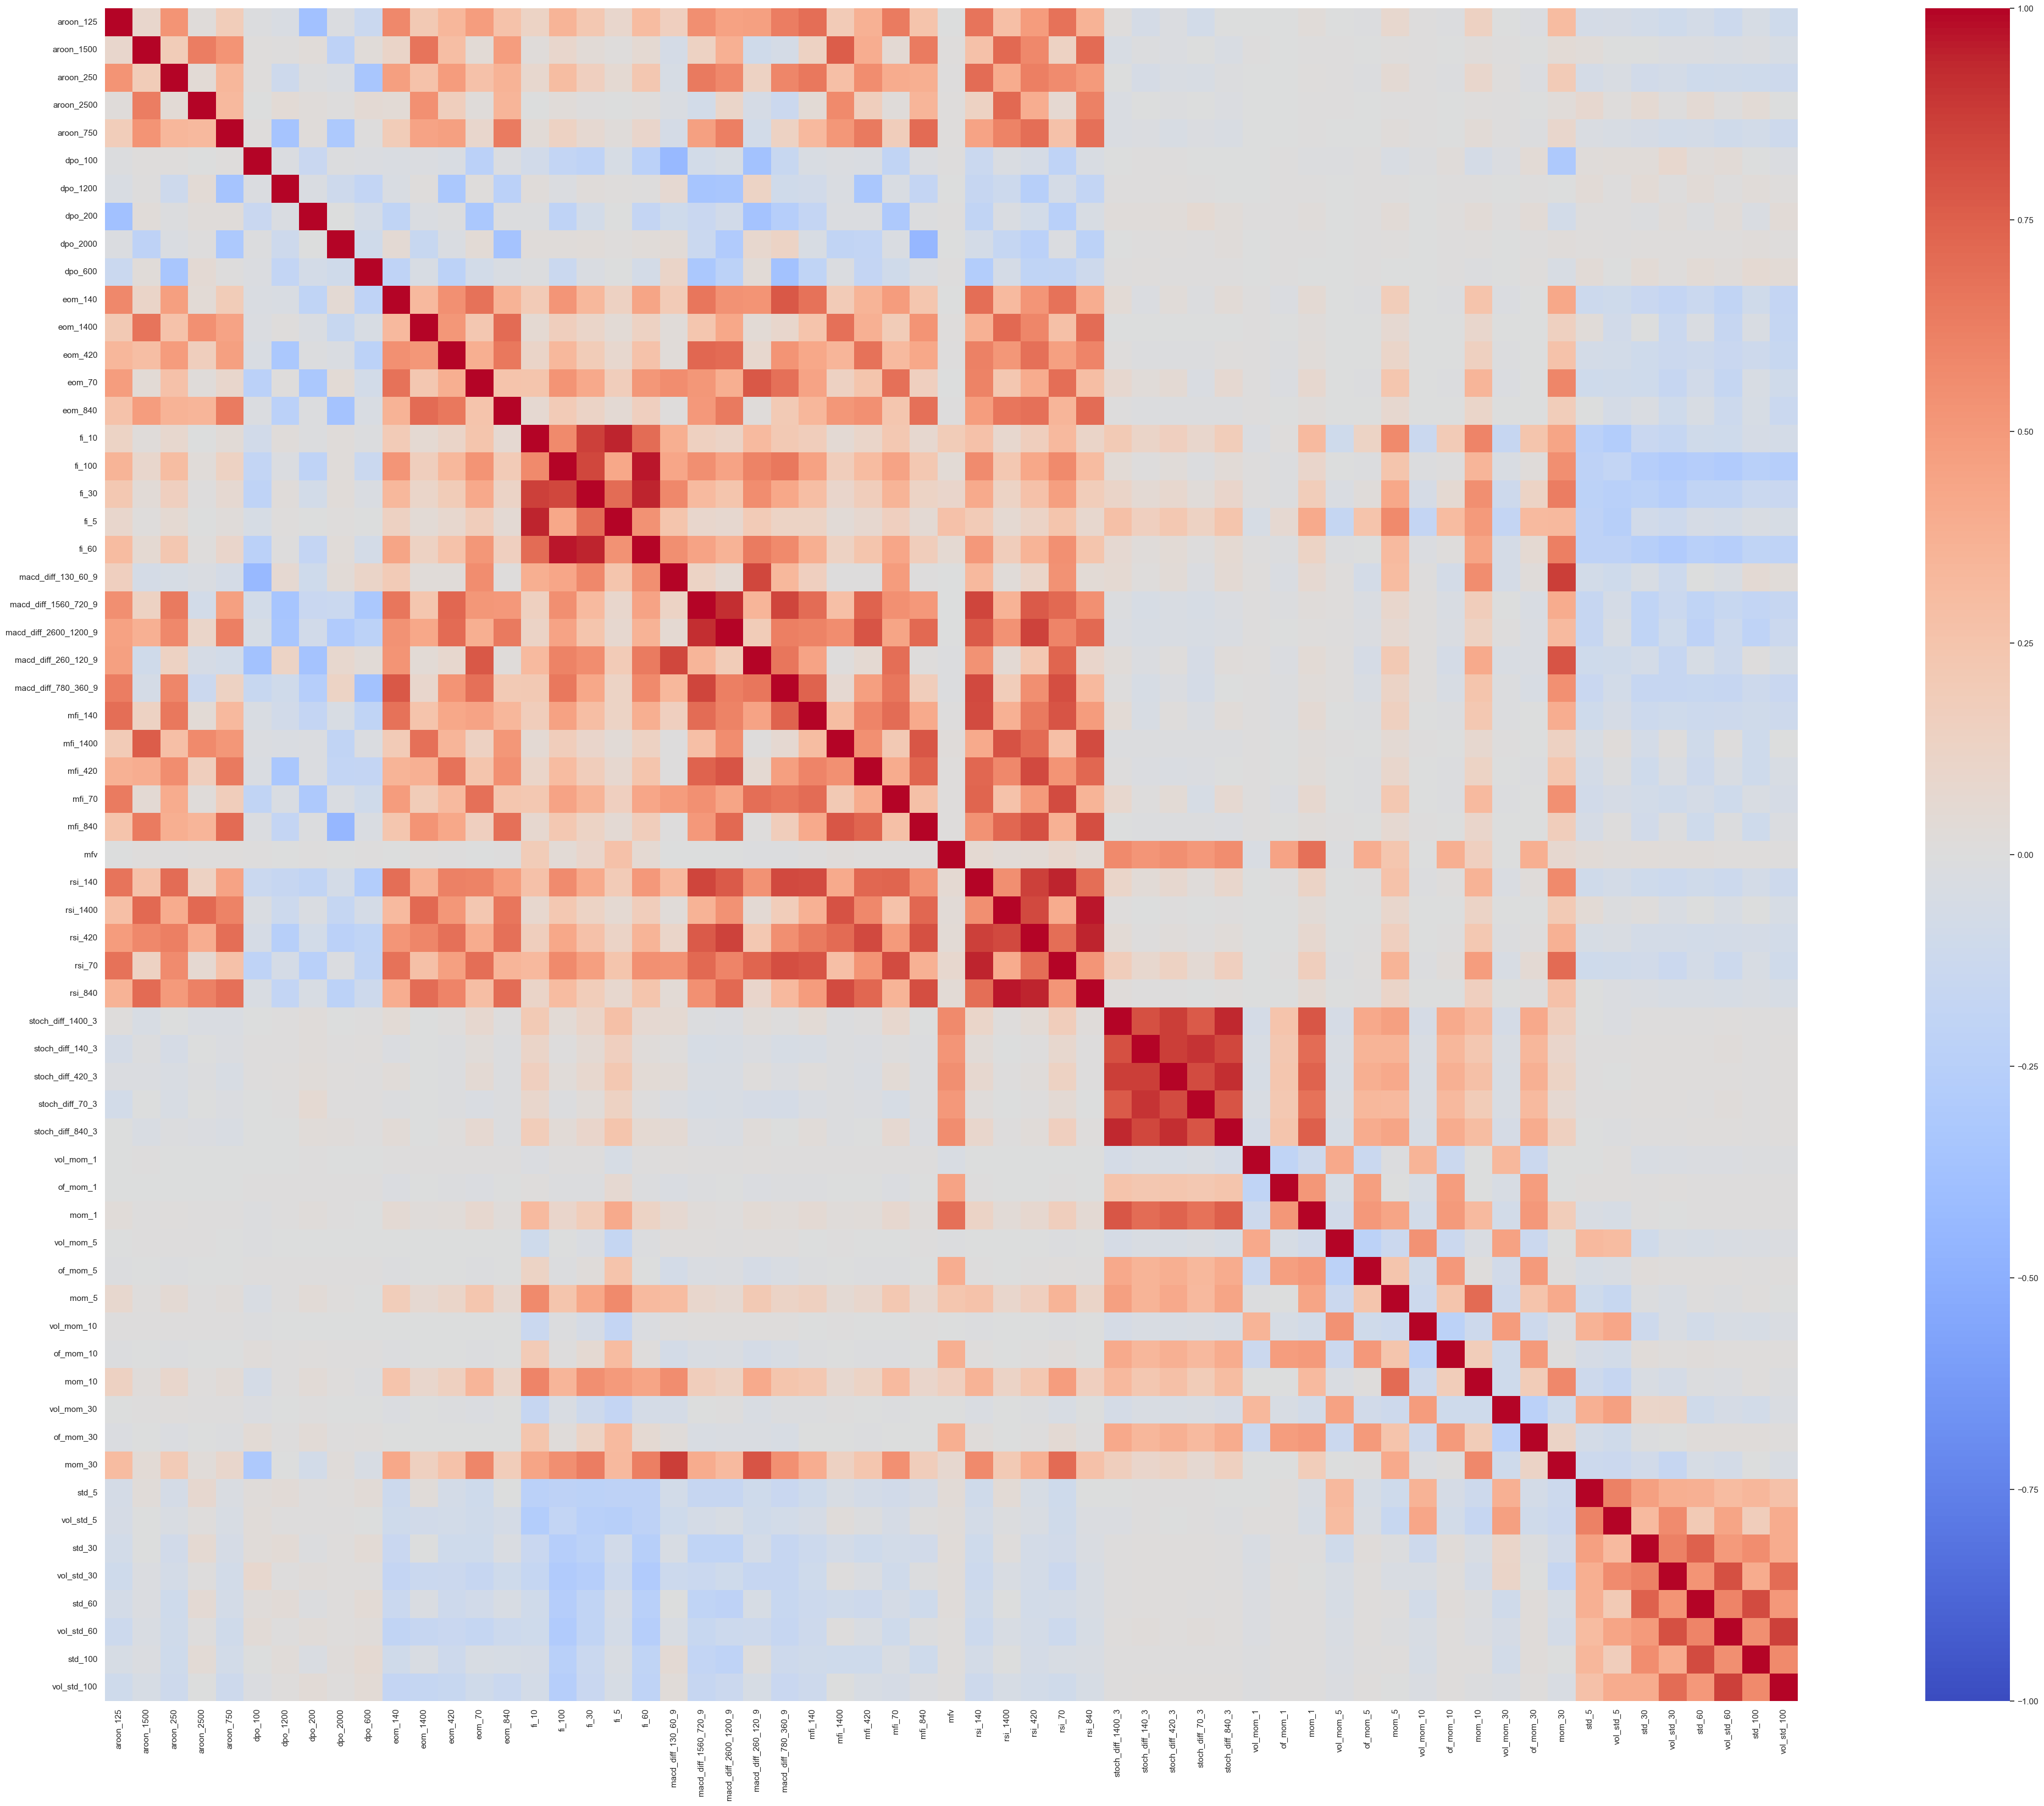

In [40]:
plt.figure(figsize=(60,40))
sns.heatmap(corr, cmap='coolwarm', vmin=-1,vmax=1, square=True)
plt.savefig('image/feature_corr.png')
plt.show()

You can use all features, but I remove some features that are highly linearly correlated.

In [41]:
# Highly correlated market features

h = 0.75
where = (abs(corr)>h) & (corr<1)

hc_list =[]
for i in range(len(np.where(where)[0])):
    hc_list.append(sorted([corr.columns[np.where(where)[0][i]], corr.columns[np.where(where)[1][i]]]))
hc_list = np.array(sorted(hc_list))[::2,:]
hc_list


array([['aroon_1500', 'mfi_1400'],
       ['eom_140', 'macd_diff_780_360_9'],
       ['eom_70', 'macd_diff_260_120_9'],
       ['fi_10', 'fi_30'],
       ['fi_10', 'fi_5'],
       ['fi_100', 'fi_30'],
       ['fi_100', 'fi_60'],
       ['fi_30', 'fi_60'],
       ['macd_diff_130_60_9', 'macd_diff_260_120_9'],
       ['macd_diff_130_60_9', 'mom_30'],
       ['macd_diff_1560_720_9', 'macd_diff_2600_1200_9'],
       ['macd_diff_1560_720_9', 'macd_diff_780_360_9'],
       ['macd_diff_1560_720_9', 'rsi_140'],
       ['macd_diff_1560_720_9', 'rsi_420'],
       ['macd_diff_2600_1200_9', 'mfi_420'],
       ['macd_diff_2600_1200_9', 'rsi_140'],
       ['macd_diff_2600_1200_9', 'rsi_420'],
       ['macd_diff_260_120_9', 'mom_30'],
       ['macd_diff_780_360_9', 'rsi_140'],
       ['macd_diff_780_360_9', 'rsi_70'],
       ['mfi_140', 'rsi_140'],
       ['mfi_140', 'rsi_70'],
       ['mfi_1400', 'mfi_840'],
       ['mfi_1400', 'rsi_1400'],
       ['mfi_1400', 'rsi_840'],
       ['mfi_420', 'rsi_420

In [42]:
drop_features = np.unique(hc_list[:,1])
drop_features

array(['fi_30', 'fi_5', 'fi_60', 'macd_diff_2600_1200_9',
       'macd_diff_260_120_9', 'macd_diff_780_360_9', 'mfi_1400',
       'mfi_420', 'mfi_840', 'mom_30', 'rsi_140', 'rsi_1400', 'rsi_420',
       'rsi_70', 'rsi_840', 'std_60', 'stoch_diff_1400_3',
       'stoch_diff_140_3', 'stoch_diff_420_3', 'stoch_diff_70_3',
       'stoch_diff_840_3', 'vol_std_60'], dtype='<U21')

In [43]:
mkt1 = mkt.drop(columns=drop_features)
corr2 = mkt1.corr()

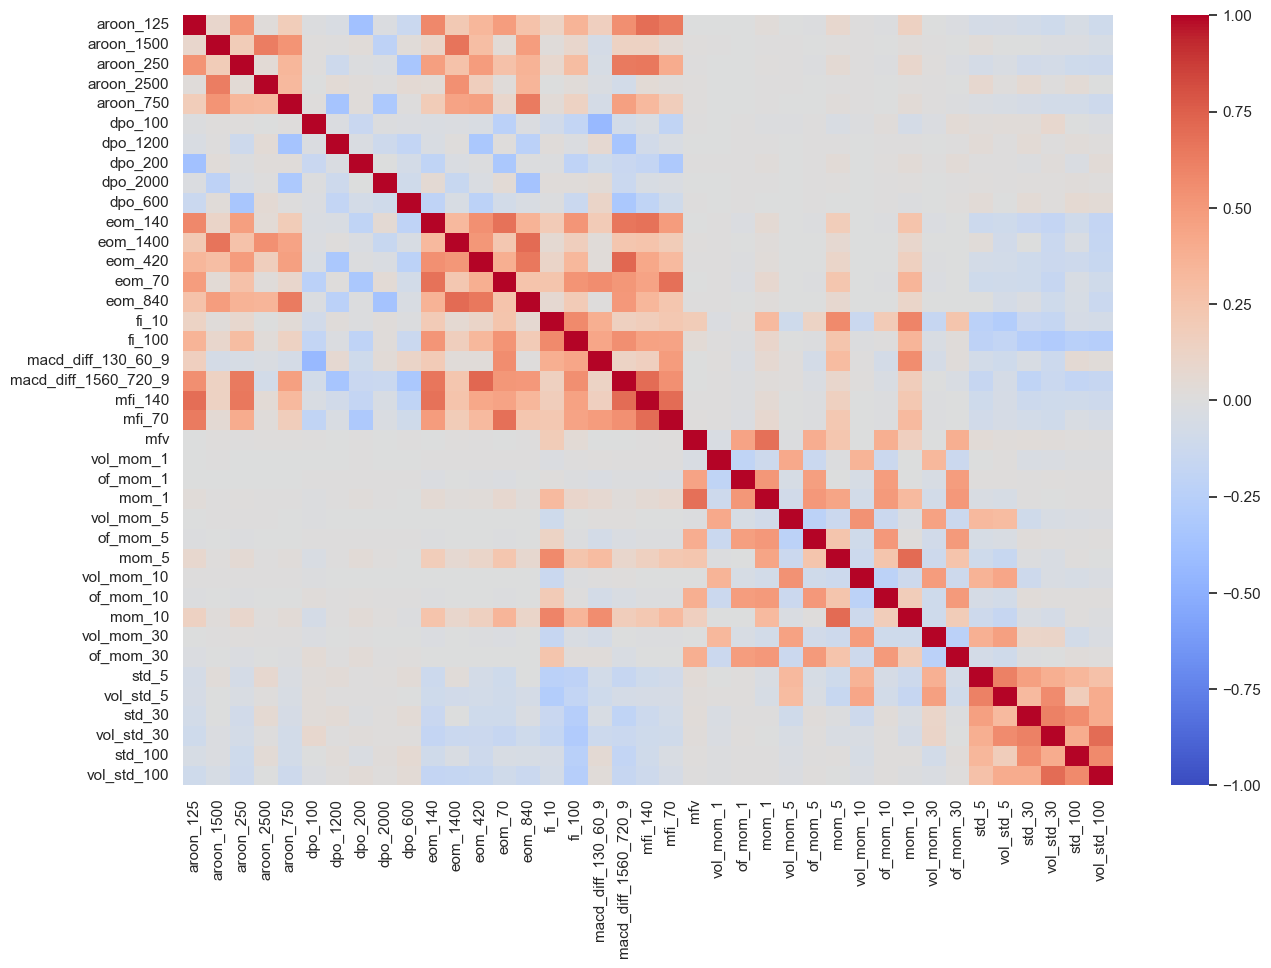

In [44]:
plt.figure(figsize=(15,10))
sns.heatmap(corr2, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr2.png')
plt.show()

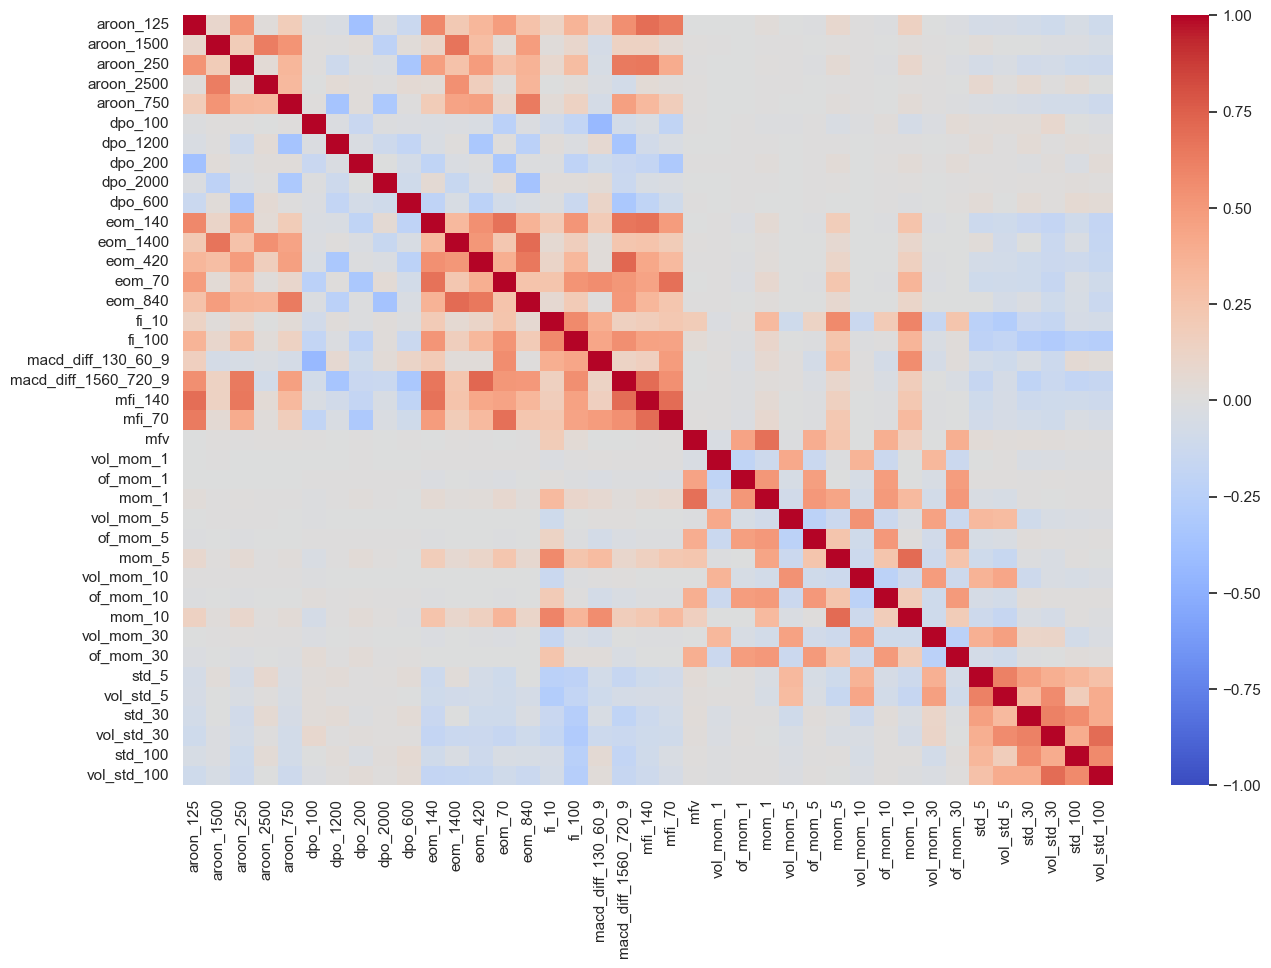

In [45]:
corr2 = mkt1.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr2, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr2.png')
plt.show()

### Market Microstructures

We don't have tick data to build microstructure features.

It would be very helpful with that data.

### Fundamentals

It is not easy to get fundamental data for 5 minutes Ethereum price.

### Sentiments

We can get features from Natural Language Process.

Working on this.

In [46]:
raw_X = mkt1.shift(1).copy()

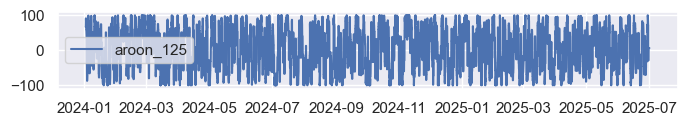

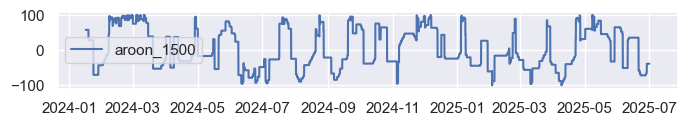

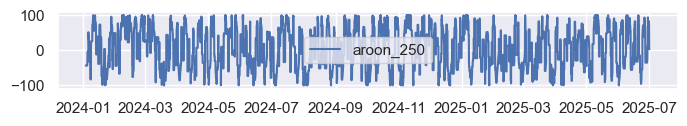

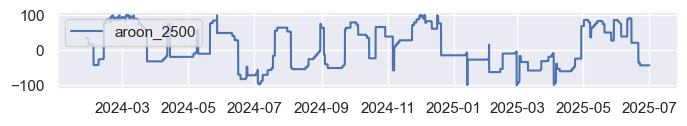

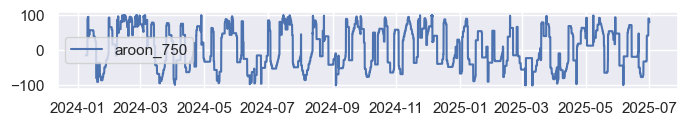

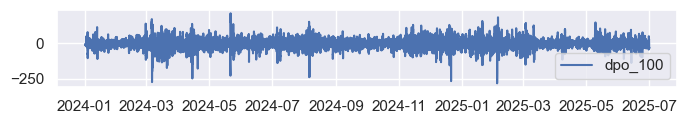

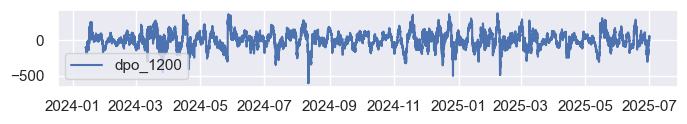

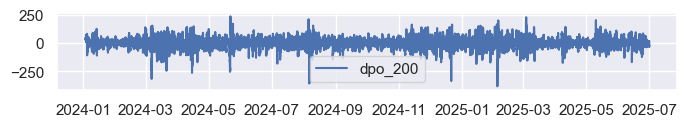

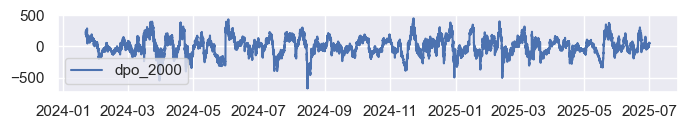

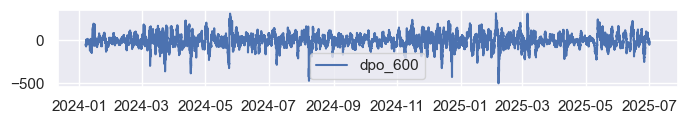

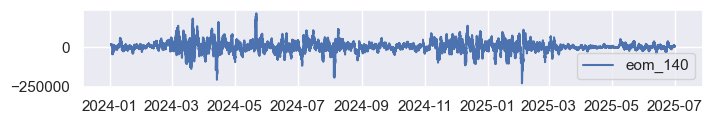

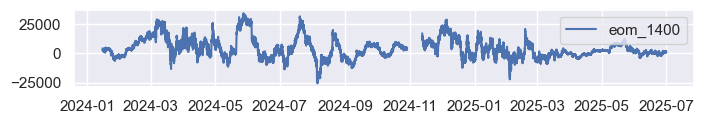

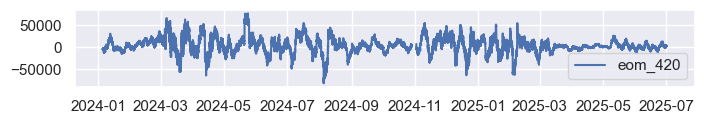

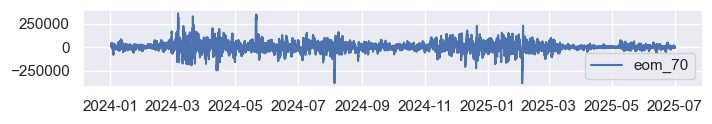

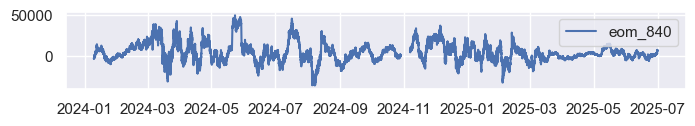

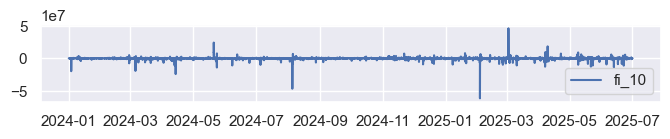

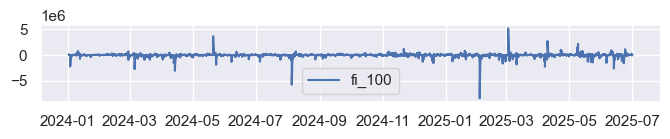

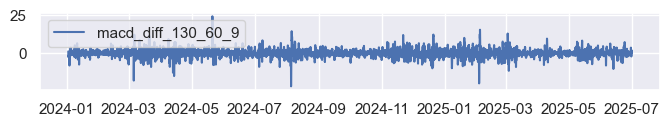

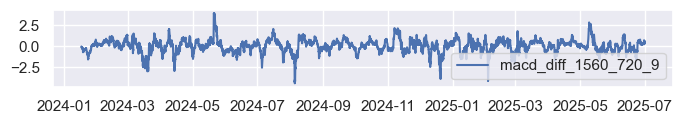

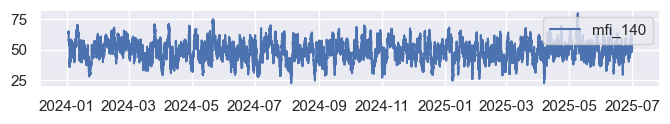

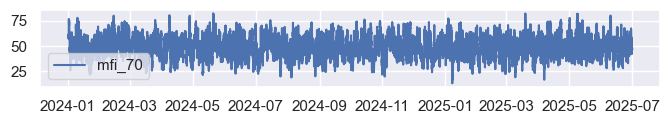

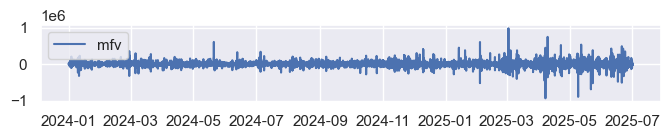

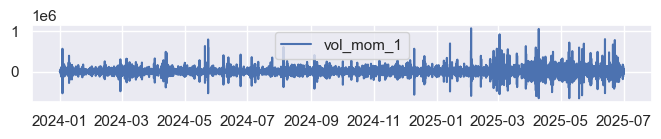

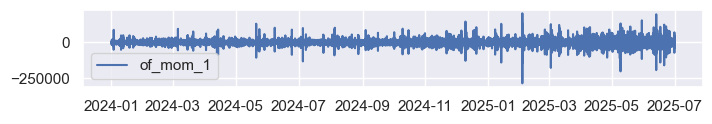

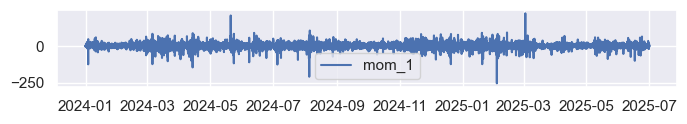

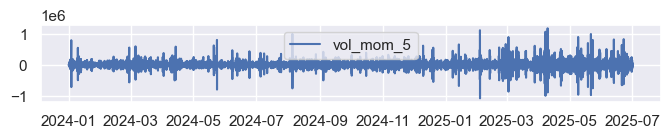

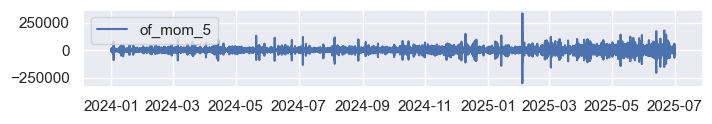

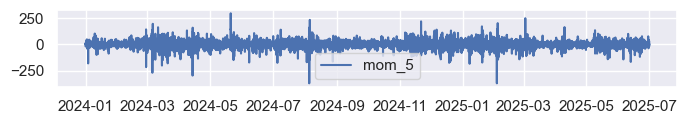

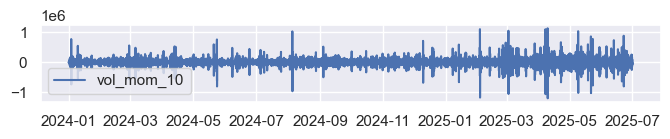

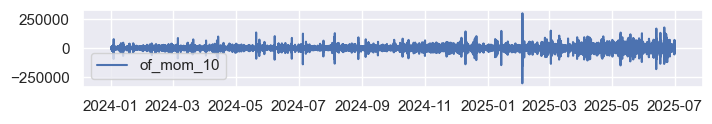

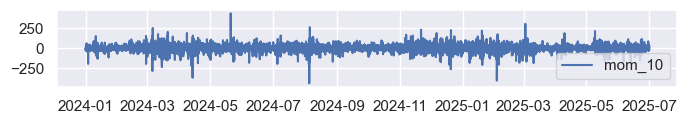

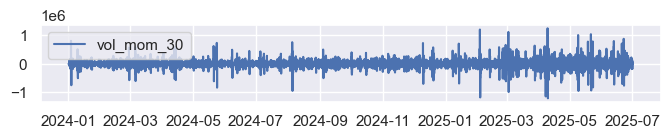

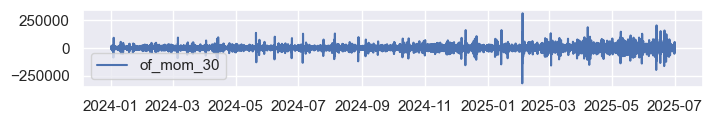

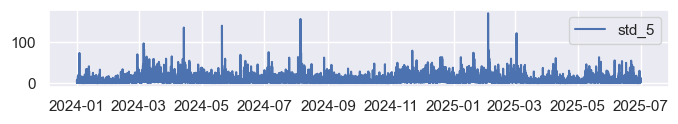

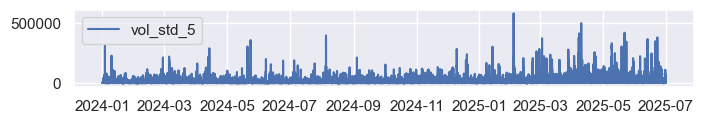

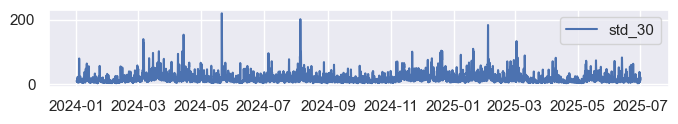

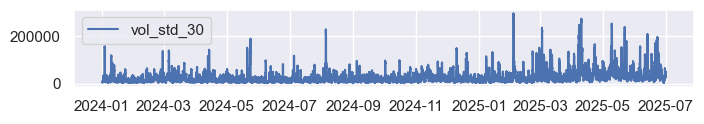

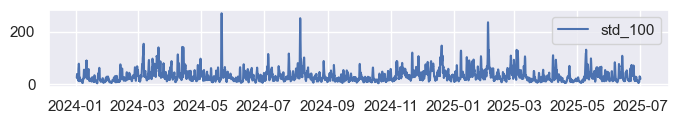

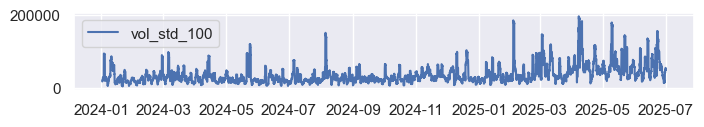

In [47]:
for i in raw_X.columns:
    plt.figure(figsize=(8,1))
    plt.plot(raw_X[i])
    plt.legend([i])

## Feature Engineering

### Feature Scaling

Do it train, test data seperately.
I fit the scaler only on the training dataset and then transform the test set.

*Due to computational cost (in autoencoders), I did scaling and dimension-reduction of index of meta-labels'.*


MINMAX

In [48]:
train_index = y.loc[:end_date_train]
test_index = y.loc[start_date_test:]

In [49]:
raw_X_train = raw_X.loc[train_index.index].dropna()
raw_X_test = raw_X.loc[test_index.index].dropna()

In [50]:
scaler = preprocessing.MinMaxScaler((0,1))
scaler.fit(raw_X_train)

scaled_X_train = pd.DataFrame(scaler.transform(raw_X_train),index=raw_X_train.index,columns=raw_X.columns)
scaled_X_test = pd.DataFrame(scaler.transform(raw_X_test),index=raw_X_test.index,columns=raw_X.columns)

### Dimension Reduction
- PCA - linear
- Deep Autoencoder (in process) - non-linear

CNN-autoencoder

https://github.com/jo-cho/machine-learning-for-trading/blob/master/18_convolutional_neural_nets/07_cnn_for_trading.ipynb

https://github.com/jo-cho/ML_Finance_Codes/blob/master/Chapter8-Advanced-NNs/ML_in_Finance-RNNs-Bitcoin.ipynb

In [51]:
# PCA
n=5

pca = PCA(n)
pca.fit(scaled_X_train)

pca_X_train = pd.DataFrame(pca.transform(scaled_X_train),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_train.index)

pca_X_test = pd.DataFrame(pca.transform(scaled_X_test),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_test.index)

In [52]:
components_ = pca.components_

In [53]:
loadings = pd.DataFrame(components_, index = pca_X_train.columns, columns=mkt1.columns).T

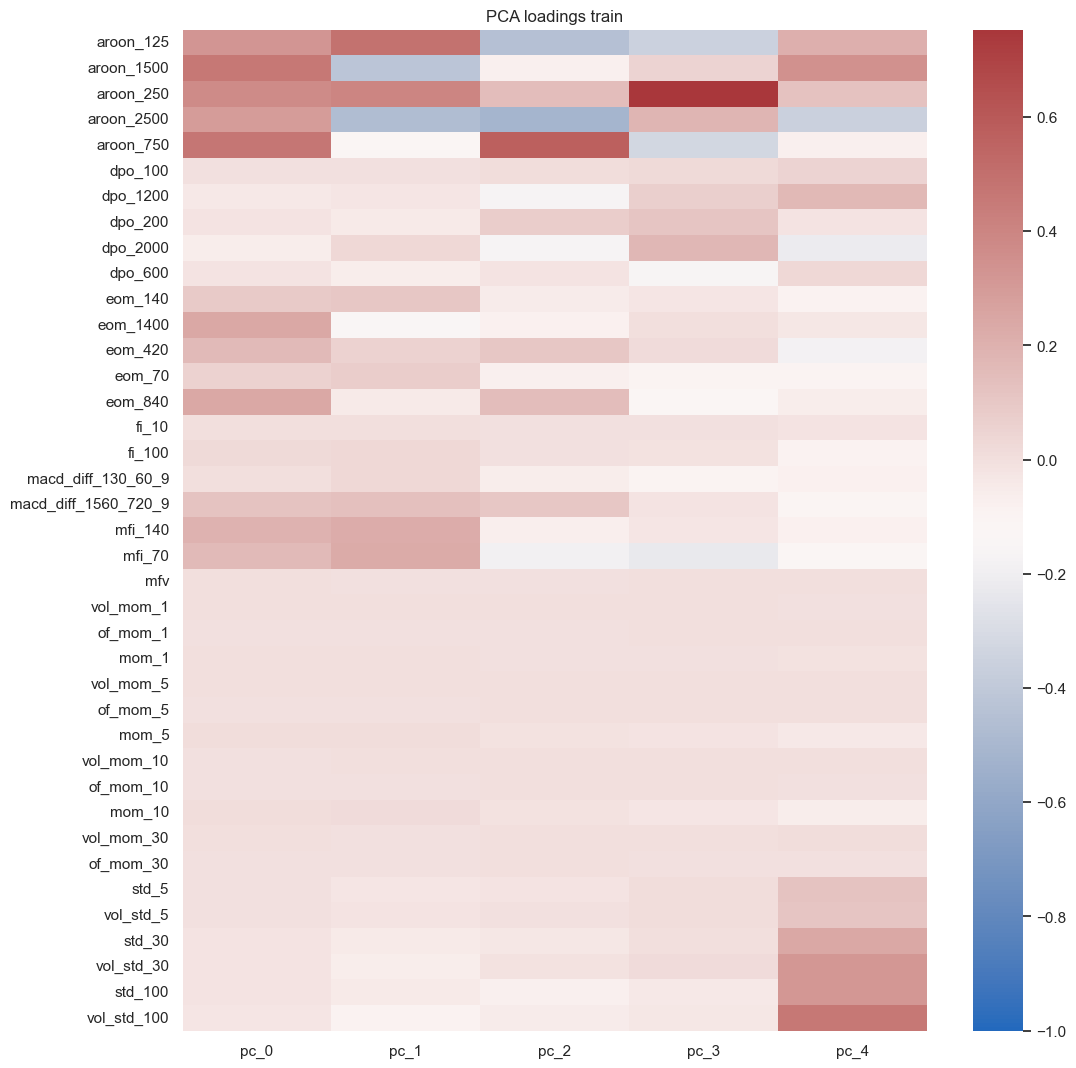

In [54]:
f = plt.figure(figsize=(12, 13))
sns.heatmap(loadings,cmap='vlag',vmin=-1)
plt.title('PCA loadings train')
plt.savefig('image/pcaloadings.jpg')
plt.show();

**Deep Autoencoders**

Non-Linear stacked autoencoders

https://towardsdatascience.com/dimensionality-reduction-with-autoencoders-versus-pca-f47666f80743

In [55]:
x = scaled_X_train.copy()

epochs=100
dimension=5

In [56]:
keras.backend.clear_session()

In [57]:
nl_encoder = keras.models.Sequential([
    keras.layers.Dense(20, input_shape=[x.shape[1]], activation='relu'),
    keras.layers.Dense(15, activation='selu'),
    keras.layers.Dense(dimension, activation='selu'),
])

nl_decoder = keras.models.Sequential([
    keras.layers.Dense(15, input_shape=[dimension], activation='selu'),
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(x.shape[1], activation='relu'),
])

nl_autoencoder = keras.models.Sequential([nl_encoder, nl_decoder])
nl_autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.1))
nl_autoencoder.summary()


history = nl_autoencoder.fit(x,x, epochs=epochs, callbacks=[keras.callbacks.EarlyStopping(monitor='loss',patience=10)],
                             verbose=1)

2025-12-22 23:16:41.313433: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-12-22 23:16:41.313463: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-22 23:16:41.313479: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-22 23:16:41.313493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-22 23:16:41.313507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 5)              │         1,195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 39)             │         1,229 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,424 (9.47 KB)

 Trainable params: 2,424 (9.47 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
  1/493 ━━━━━━━━━━━━━━━━━━━━ 1:51 226ms/step - loss: 0.5585

2025-12-22 23:16:41.548594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.5367
Epoch 2/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.5753
Epoch 3/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.5935
Epoch 4/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6064
Epoch 5/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6140
Epoch 6/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6143
Epoch 7/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6178
Epoch 8/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6257
Epoch 9/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6394
Epoch 10/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.6472
Epoch 11/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6530


In [58]:
encoded_X_train = nl_encoder.predict(scaled_X_train)
encoded_X_train = pd.DataFrame(encoded_X_train, index=scaled_X_train.index,columns=['encoded_{}'.format(i) for i in range(dimension)])

encoded_X_test = nl_encoder.predict(scaled_X_test)
encoded_X_test = pd.DataFrame(encoded_X_test, index=scaled_X_test.index,columns=['encoded_{}'.format(i) for i in range(dimension)])

493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [59]:
encoded_X_train

encoded_0  encoded_1  encoded_2  encoded_3  encoded_4
open_time                                                                 
2024-01-27 01:15:00   0.945406   2.521634   1.749916  -1.017869   0.182290
2024-01-27 02:00:00   0.958953   2.522281   1.723746  -1.018948   0.189338
2024-01-27 02:30:00   0.944416   2.524571   1.730078  -1.016308   0.208878
2024-01-27 02:45:00   0.945584   2.510099   1.722317  -1.011548   0.208675
2024-01-27 03:15:00   0.956692   2.514220   1.731879  -1.008982   0.195581
...                        ...        ...        ...        ...        ...
2025-01-01 22:15:00   0.936901   1.876028   1.750733  -0.574749   0.310594
2025-01-01 22:30:00   0.922989   1.887999   1.769257  -0.589695   0.319649
2025-01-01 23:00:00   0.941952   1.892303   1.750183  -0.591696   0.298055
2025-01-01 23:30:00   0.907612   1.875761   1.744856  -0.590319   0.322223
2025-01-01 23:45:00   0.911269   1.886713   1.739640  -0.601381   0.314518

[15766 rows x 5 columns]

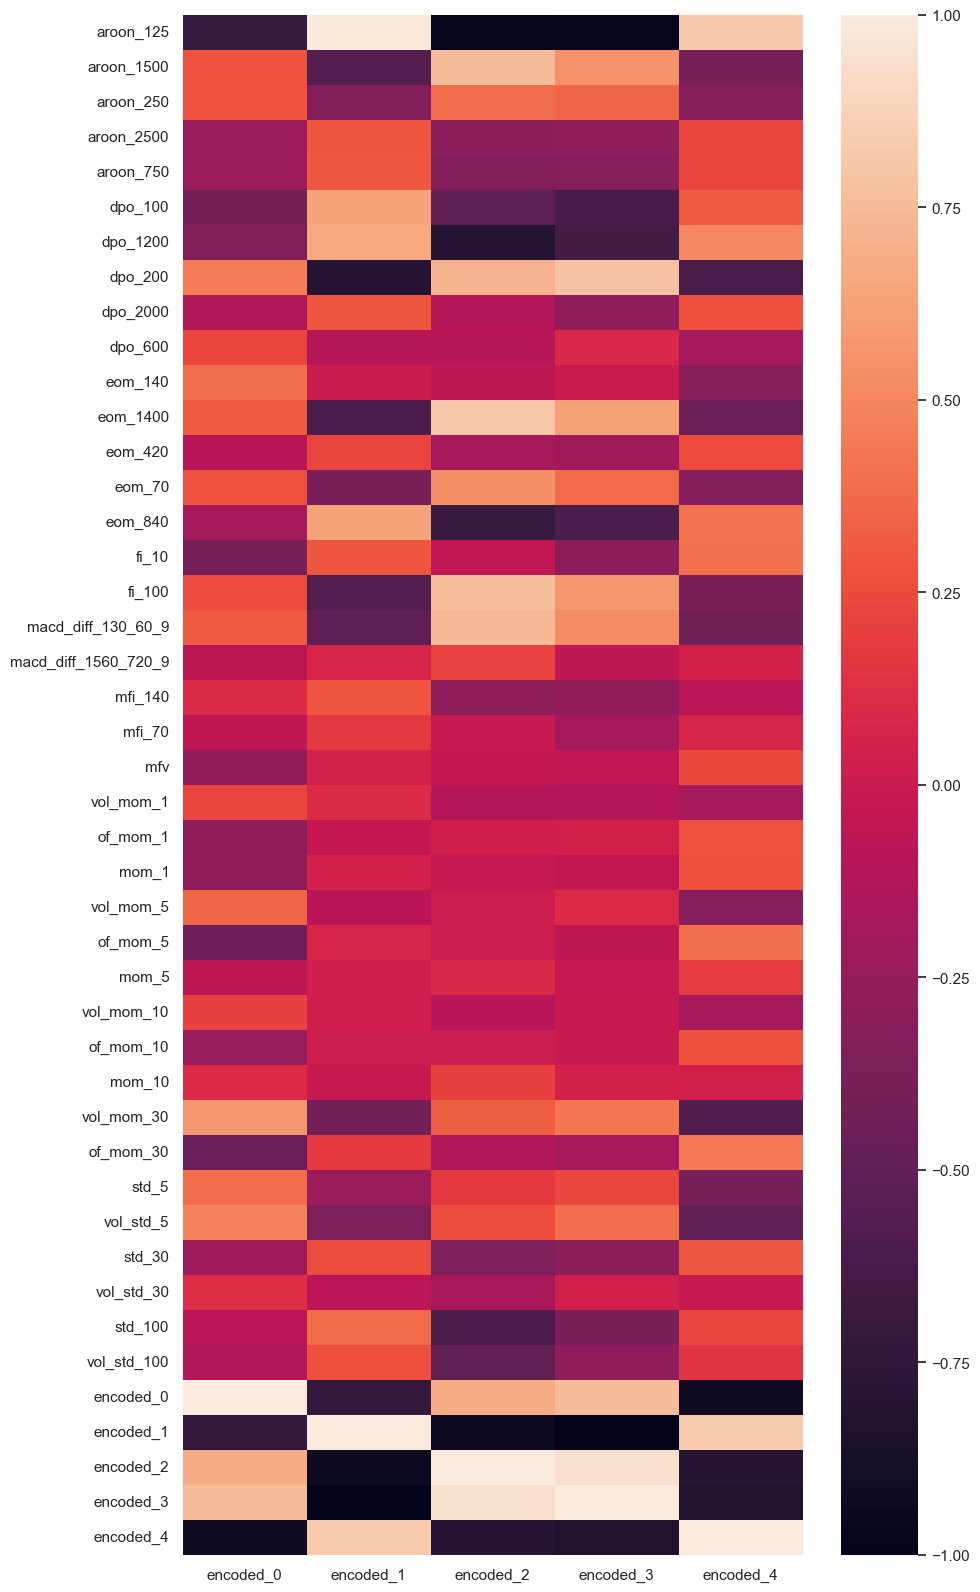

In [60]:
corr_encoded = scaled_X_test.join(encoded_X_train).corr().iloc[-5:].T

plt.figure(figsize=(10,20))
sns.heatmap(corr_encoded,vmin=-1,vmax=1)
plt.show()

COMPARE PCA and Non-linear autoencoder

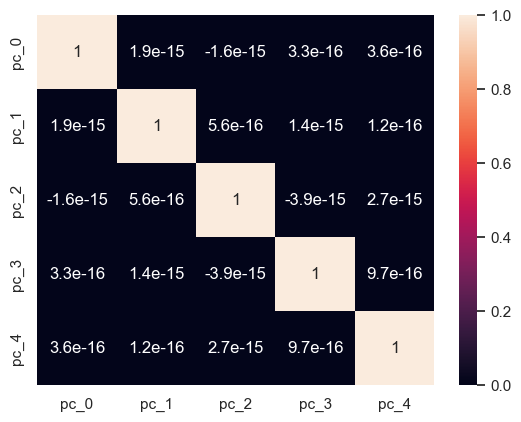

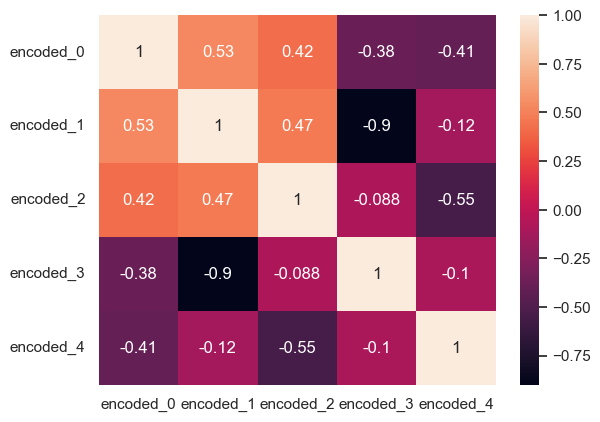

In [61]:
# correlation (linearly)
sns.heatmap(pca_X_train.corr(),annot=True)
plt.show()

sns.heatmap(encoded_X_train.corr(),annot=True)
plt.show()

# Machine Learning Model

## Hyper parameter tuning

We have to focus on **precision score**(in symmetric barrier) or **f1 score**

because

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, it helps.

or F1 socre in general(*suggested by De Prado): Accuracy may not be an adequate classification score for meta-labeling
applications. 
- Suppose that, after you apply meta-labeling, there are many more
negative cases (label ‘0’) than positive cases (label ‘1’). Under that scenario, a
classifier that predicts every case to be negative will achieve high accuracy, even
though recall=0 and precision is undefined. The F1 score corrects for that flaw,
by assessing the classifier in terms of the (equally weighted) harmonic mean of
precision and recall,

In [62]:
train_X = pca_X_train.copy() 
# or
#train_X= encoded_X_train.copy()

test_X = pca_X_test.copy()
# or
#test_X= encoded_X_test.copy()<Increasing p (probability of winning)>

FYI using encoded_X, the best precision score of auto ML models is around 0.66

In [63]:
train_data = train_X.join(train_y).dropna()
test_data = test_X.join(test_y).dropna()

## AutoML with autogluon and select the best model

In [64]:
from autogluon.tabular import TabularPredictor

We have to focus on **precision score**(in symmetric barrier) or **f1 score**

because

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, this helps.

or F1 socre (*suggested by De Prado): Accuracy may not be an adequate classification score for meta-labeling
applications. Suppose that, after you apply meta-labeling, there are many more
negative cases (label ‘0’) than positive cases (label ‘1’). Under that scenario, a
classifier that predicts every case to be negative will achieve high accuracy, even
though recall=0 and precision is undefined. The F1 score corrects for that flaw,
by assessing the classifier in terms of the (equally weighted) harmonic mean of
precision and recall,

This *autogluon* supports a number of machine learning models, and automatically chooses optimal hyperparameters given which score to be optimized.

And also it does CV, but not Purged K-Fold which was suggested by De Prado

So we choose precision score to be maximized. (but there are some problems with *n*(annual betting opportuinites).)

In [65]:
predictor = TabularPredictor(label='y', eval_metric='precision').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20251222_151735"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.10.19
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Jul  5 22:17:35 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T8112
CPU Count:          8
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
Memory Avail:       5.51 GB / 16.00 GB (34.4%)
Disk Space Avail:   162.33 GB / 460.43 GB (35.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme'  : New in v1.5: The state-of-the-art for tabular data. Massively better than 'best' on datasets <100000 samples by using new Tabula

[1000]	valid_set's binary_logloss: 0.252524	valid_set's precision: 0.913551
[2000]	valid_set's binary_logloss: 0.174841	valid_set's precision: 0.947929
[3000]	valid_set's binary_logloss: 0.142165	valid_set's precision: 0.958432
[4000]	valid_set's binary_logloss: 0.124771	valid_set's precision: 0.959906
[5000]	valid_set's binary_logloss: 0.115794	valid_set's precision: 0.957845


	0.961	 = Validation score   (precision)
	22.83s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: LightGBM ...
	Fitting with cpus=8, gpus=0, mem=0.0/5.5 GB


[1000]	valid_set's binary_logloss: 0.150062	valid_set's precision: 0.945093


	0.9494	 = Validation score   (precision)
	4.82s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestGini ...
	Fitting with cpus=8, gpus=0, mem=0.1/5.6 GB
	0.9578	 = Validation score   (precision)
	1.21s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForestEntr ...
	Fitting with cpus=8, gpus=0, mem=0.1/5.5 GB
	0.9565	 = Validation score   (precision)
	1.49s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: CatBoost ...
	Fitting with cpus=8, gpus=0
	0.9439	 = Validation score   (precision)
	8.3s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	Fitting with cpus=8, gpus=0, mem=0.1/5.5 GB
	0.9705	 = Validation score   (precision)
	0.42s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	Fitting with cpus=8, gpus=0, mem=0.1/5.5 GB
	0.9658	 = Validation score   (precision)
	0.43s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetF

[1000]	valid_set's binary_logloss: 0.130949	valid_set's precision: 0.957746


	0.96	 = Validation score   (precision)
	16.88s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Fitting 1 model on all data | Fitting with cpus=8, gpus=0, mem=0.0/5.5 GB
	Ensemble Weights: {'ExtraTreesGini': 0.667, 'NeuralNetFastAI': 0.167, 'NeuralNetTorch': 0.167}
	0.9737	 = Validation score   (precision)
	0.18s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 105.7s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 28002.2 rows/s (1577 batch size)
Disabling decision threshold calibration for metric `precision` to avoid undefined results. Force calibration via specifying `calibrate_decision_threshold=True`.
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/Users/aming/project/python/crypto-trading-rules/AutogluonModels/ag-20251222_151735")


limitation
- shuffle 
- not good cv for finance data

In [66]:
result = predictor.leaderboard(test_data, silent=True)
result

model  score_test  score_val eval_metric  pred_time_test  \
0         LightGBMLarge    0.518954   0.959953   precision        0.131841   
1            LightGBMXT    0.514780   0.961039   precision        0.459862   
2               XGBoost    0.514539   0.958531   precision        0.043227   
3      RandomForestEntr    0.512531   0.956522   precision        0.058773   
4              CatBoost    0.511429   0.943860   precision        0.016446   
5        NeuralNetTorch    0.510563   0.969660   precision        0.014627   
6      RandomForestGini    0.510218   0.957796   precision        0.063320   
7        ExtraTreesGini    0.509881   0.970484   precision        0.092321   
8        ExtraTreesEntr    0.509603   0.965802   precision        0.095106   
9              LightGBM    0.507256   0.949352   precision        0.064545   
10  WeightedEnsemble_L2    0.503019   0.973747   precision        0.160652   
11      NeuralNetFastAI    0.488349   0.893491   precision        0.051853   

    pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0        0.027492  16.877001                 0.131841                0.027492   
1        0.101226  22.825686                 0.459862                0.101226   
2        0.007924   3.649314                 0.043227                0.007924   
3        0.024816   1.494402                 0.058773                0.024816   
4        0.002472   8.295042                 0.016446                0.002472   
5        0.004381  38.374525                 0.014627                0.004381   
6        0.027469   1.211280                 0.063320                0.027469   
7        0.039330   0.419633                 0.092321                0.039330   
8        0.038610   0.427391                 0.095106                0.038610   
9        0.019010   4.824151                 0.064545                0.019010   
10       0.056317  45.196004                 0.001851                0.001082   
11       0.011524   6.226170                 0.051853                0.011524   

    fit_time_marginal  stack_level  can_infer  fit_order  
0           16.877001            1       True         11  
1           22.825686            1       True          1  
2            3.649314            1       True          9  
3            1.494402            1       True          4  
4            8.295042            1       True          5  
5           38.374525            1       True         10  
6            1.211280            1       True          3  
7            0.419633            1       True          6  
8            0.427391            1       True          7  
9            4.824151            1       True          2  
10           0.175676            2       True         12  
11           6.226170            1       True          8

In [67]:
best_model = result.model[0]

In [68]:
y_true2 = test_data.y
y_pred2 = predictor.predict(test_data, model=best_model)

print(best_model, "'s predictions:  \n", y_pred2)
perf = predictor.evaluate_predictions(y_true=y_true2, y_pred=y_pred2, auxiliary_metrics=True)

LightGBMLarge 's predictions:  
 open_time
2025-01-01 00:00:00    1.0
2025-01-01 00:15:00    1.0
2025-01-01 00:30:00    1.0
2025-01-01 00:45:00    1.0
2025-01-01 01:30:00    1.0
                      ... 
2025-06-23 21:00:00   -1.0
2025-06-24 03:45:00   -1.0
2025-06-24 04:15:00   -1.0
2025-06-24 04:30:00   -1.0
2025-06-27 18:45:00    1.0
Name: y, Length: 8413, dtype: float64


## Feature Importance

In autogluon,

- A feature's importance score represents the performance drop that results when the model makes predictions on a perturbed copy of the data where this feature's values have been randomly shuffled across rows.
- A feature score of 0.01 would indicate that the predictive performance dropped by 0.01 when the feature was randomly shuffled.
- The higher the score a feature has, the more important it is to the model's performance.
- If a feature has a negative score, this means that the feature is likely harmful to the final model, and a model trained with the feature removed would be expected to achieve a better predictive performance.

In [69]:
for i in result.model:
    print(i, "'s Feature Importance")
    fi = predictor.feature_importance(test_data, model=i, silent=True)
    print(fi)
    print('\n')

LightGBMLarge 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_3    0.006420  0.003571  0.007930  5  0.013772 -0.000932
pc_4    0.003771  0.003835  0.046391  5  0.011668 -0.004125
pc_0   -0.001725  0.003338  0.843960  5  0.005147 -0.008597
pc_2   -0.004517  0.003301  0.981165  5  0.002280 -0.011314
pc_1   -0.010605  0.003263  0.999047  5 -0.003885 -0.017324


LightGBMXT 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_3    0.008718  0.003122  0.001677  5  0.015146  0.002289
pc_2    0.004656  0.004645  0.044252  5  0.014221 -0.004909
pc_0    0.000512  0.003214  0.369893  5  0.007131 -0.006107
pc_1   -0.006711  0.002908  0.996653  5 -0.000724 -0.012699
pc_4   -0.007269  0.007526  0.951533  5  0.008228 -0.022765


XGBoost 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_3    0.010219  0.004470  0.003464  5  0.019423  0.001014
pc_2   -0.002183  0.005212  0.799005  5  0.008548 -0.0129

## Results with PnL

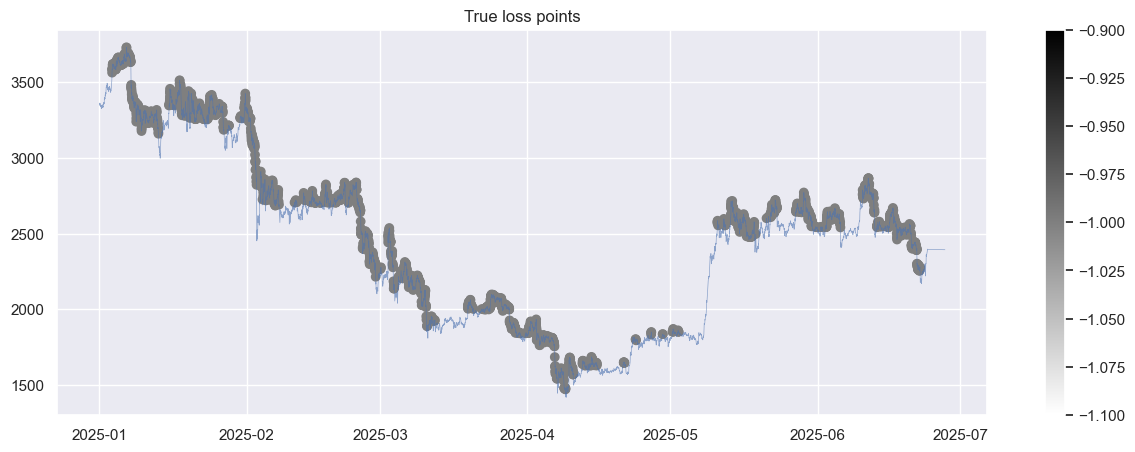

In [70]:
sc = y_true2.loc[y_true2==-1]
title = 'True loss points'
figure_scatter(sc,close.loc[y_true2.index],title,cmap='gray_r')

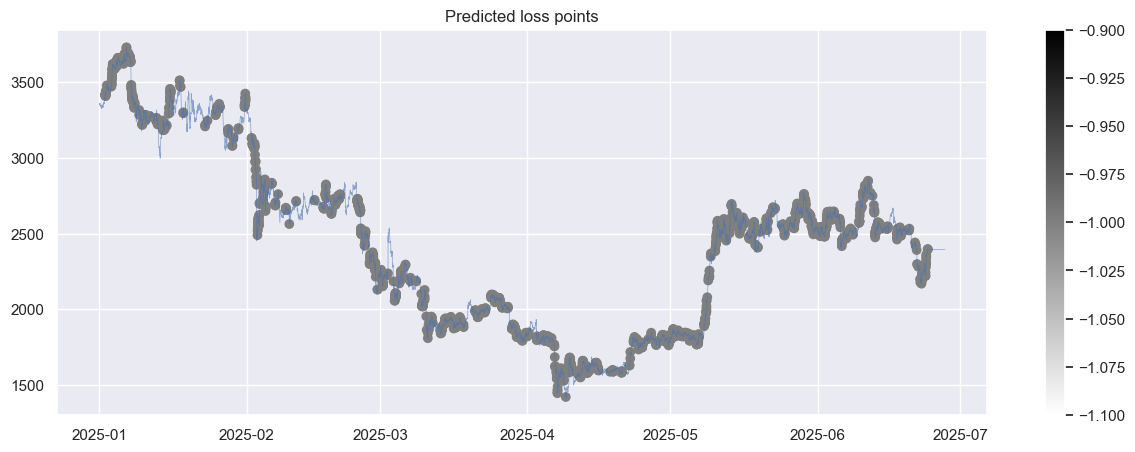

In [71]:
sc = y_pred2.loc[y_pred2==-1]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [72]:
# After drop predicted loss
predlabel = y_true2.drop(index=y_pred2.loc[y_pred2==-1].index)
predlabel.value_counts()

y
 1.0    2957
-1.0    2741
Name: count, dtype: int64

In [73]:
print('이익확률 pi: ',predlabel.value_counts().values[0] / predlabel.value_counts().values.sum())

이익확률 pi:  0.5189540189540189


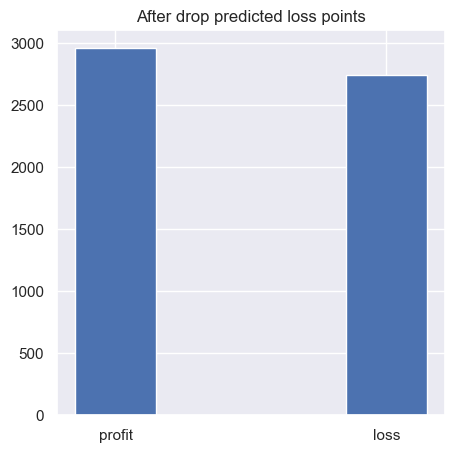

In [74]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel.value_counts(), width=0.3)
plt.title('After drop predicted loss points')
plt.savefig('image/pnl_2nd.png')
plt.show()

the pitfalls of maximizing precision score:

there can be huge diminish in bet opportunities.

Using Predicted Probabilities adjust it.
from 0.5 to maybe 0.8

In [75]:
y_pred_prob2 = predictor.predict_proba(test_data)
y_pred_prob2

-1.0       1.0
open_time                              
2025-01-01 00:00:00  0.016678  0.983322
2025-01-01 00:15:00  0.034727  0.965273
2025-01-01 00:30:00  0.014674  0.985326
2025-01-01 00:45:00  0.017324  0.982676
2025-01-01 01:30:00  0.028680  0.971320
...                       ...       ...
2025-06-23 21:00:00  0.926322  0.073678
2025-06-24 03:45:00  0.915794  0.084206
2025-06-24 04:15:00  0.904519  0.095480
2025-06-24 04:30:00  0.317869  0.682131
2025-06-27 18:45:00  0.329886  0.670114

[8413 rows x 2 columns]

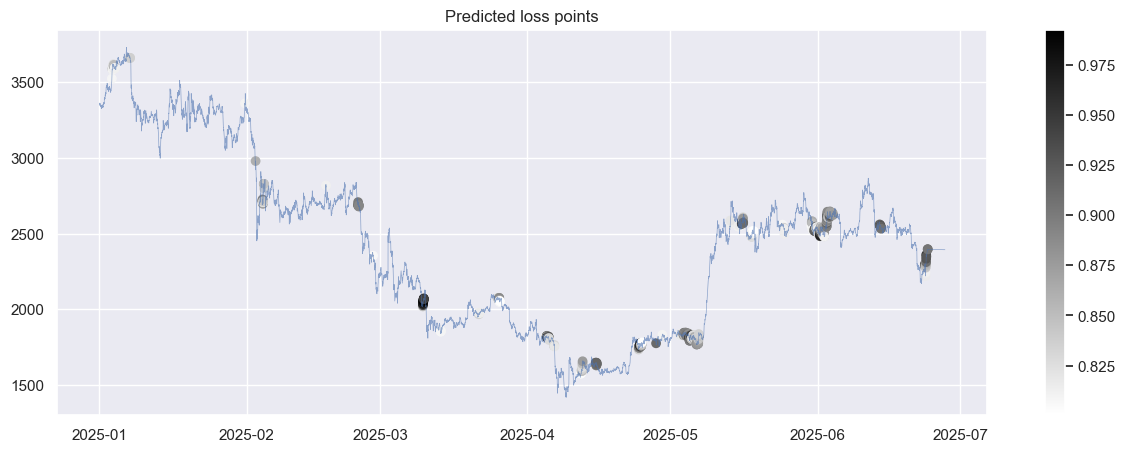

In [76]:
pred_loss = y_pred_prob2[-1]
sc = pred_loss.loc[pred_loss>0.8]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [77]:
# After drop predicted loss
predlabel2 = y_true2.drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>=0.8].index)
predlabel2.value_counts()

y
 1.0    4060
-1.0    3777
Name: count, dtype: int64

In [78]:
print('이익확률 pi: ',predlabel2.value_counts().values[0] / predlabel2.value_counts().values.sum())

이익확률 pi:  0.518055378333546


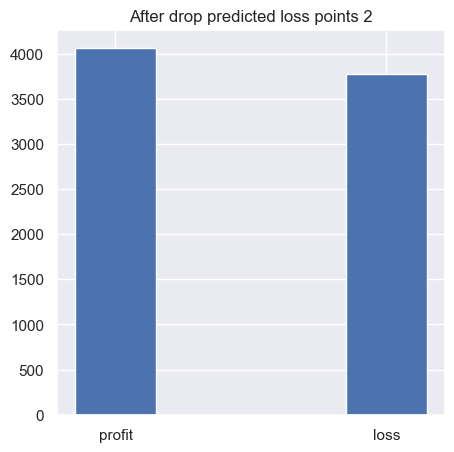

In [79]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel2.value_counts(), width=0.3)
plt.title('After drop predicted loss points 2')
plt.savefig('image/pnl_2nd2.png')
plt.show()

Solution (in process):

When choosing the optimal model, consider not only precision score but also the number of betting opportunities.

More specifically maximizing annualized Sharpe ratio.


see returns

In [80]:
finret = ret.loc[y_true2.index].drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>0.5].index)
finret

open_time
2025-01-01 00:00:00    0.051600
2025-01-01 00:15:00    0.051236
2025-01-01 00:30:00    0.049225
2025-01-01 00:45:00    0.049658
2025-01-01 01:30:00    0.050278
                         ...   
2025-06-23 12:30:00    0.061753
2025-06-23 12:45:00    0.058932
2025-06-23 13:30:00    0.049009
2025-06-24 04:30:00    0.049272
2025-06-27 18:45:00    0.049420
Name: ret, Length: 5797, dtype: float64

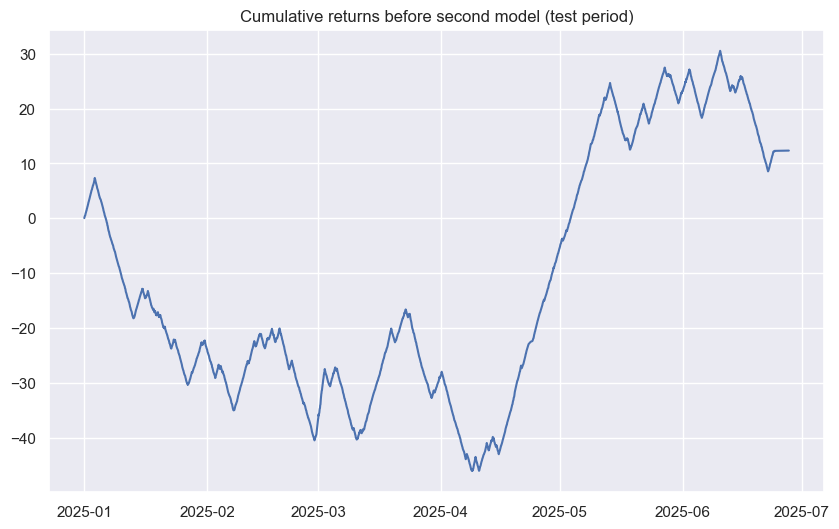

In [81]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns before second model (test period)')
plt.plot(ret.loc[y_true2.index].cumsum())
plt.savefig('image/cumsum_ret_1st_test.png')
plt.show()

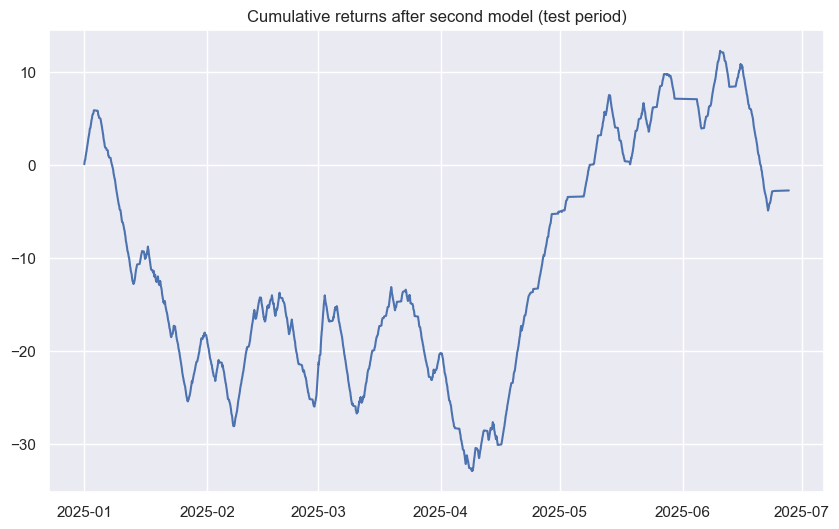

In [82]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns after second model (test period)')
plt.plot(finret.cumsum())
plt.savefig('image/cumsum_ret_2nd_test.png')
plt.show()

### Trading

#### bet sizing

- Kelly rules (when betting data is normally dist.)
- Use predicted probabilities as bet confidence (suggested by DePrado)

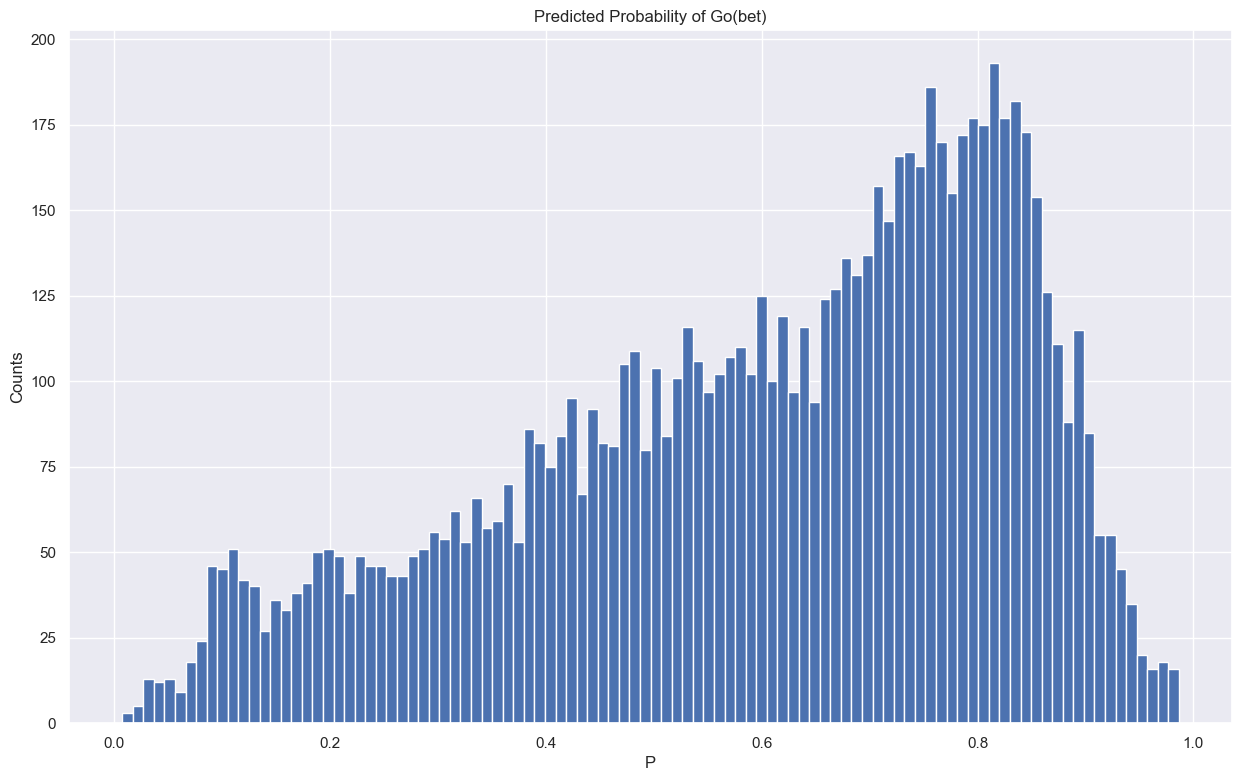

In [83]:
p = y_pred_prob2[1]
f=plt.figure(figsize=(15,9))
a = f.gca()
a.hist(p,bins=100)
plt.xlabel('P')
plt.ylabel('Counts')
plt.title('Predicted Probability of Go(bet)')
plt.savefig('image/predprob.jpg')
plt.show()

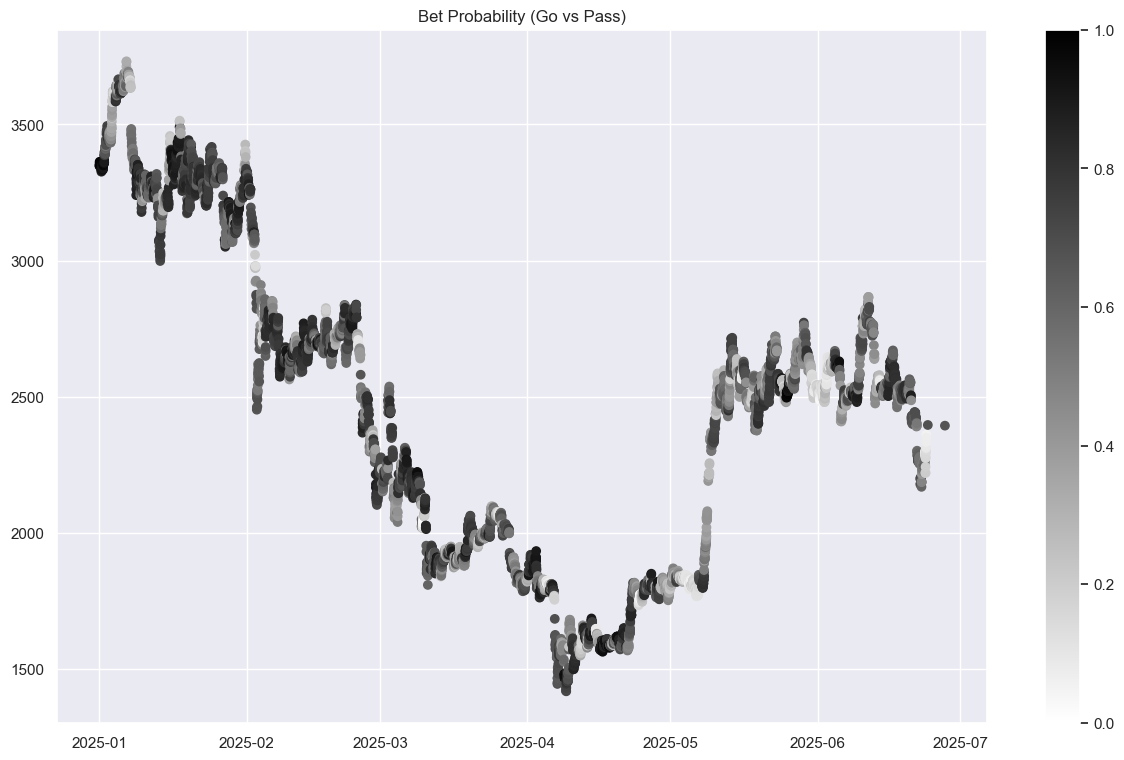

In [84]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= p, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Probability (Go vs Pass)')
plt.savefig('image/bet_prob.png')
plt.show()

## Bet Sizing

- not perfect yet

In [85]:
def get_signal(prob, num_classes):
    if prob.shape[0] == 0:
        return pd.Series(dtype='float64')

    bet_sizes = (prob - 1/num_classes) / (prob * (1 - prob))**0.5

    bet_sizes = bet_sizes.apply(lambda s: 2 * norm.cdf(s) - 1)

    return bet_sizes

In [86]:
def discretize(signal0, step_size):
    signal1 = (signal0 / step_size).round() * step_size
    signal1[signal1 > 1] = 1  # Cap
    signal1[signal1 < -1] = -1  # Floor
    return signal1

In [87]:
prob = p.copy()

m = get_signal(prob, 2)
m = discretize(m, 0.25)

In [88]:
m

open_time
2025-01-01 00:00:00    1.00
2025-01-01 00:15:00    1.00
2025-01-01 00:30:00    1.00
2025-01-01 00:45:00    1.00
2025-01-01 01:30:00    1.00
                       ... 
2025-06-23 21:00:00   -1.00
2025-06-24 03:45:00   -0.75
2025-06-24 04:15:00   -0.75
2025-06-24 04:30:00    0.25
2025-06-27 18:45:00    0.25
Name: 1.0, Length: 8413, dtype: float64

In [89]:
# we only do long position betting

m.loc[m[m<0].index] = 0
m

open_time
2025-01-01 00:00:00    1.00
2025-01-01 00:15:00    1.00
2025-01-01 00:30:00    1.00
2025-01-01 00:45:00    1.00
2025-01-01 01:30:00    1.00
                       ... 
2025-06-23 21:00:00    0.00
2025-06-24 03:45:00    0.00
2025-06-24 04:15:00    0.00
2025-06-24 04:30:00    0.25
2025-06-27 18:45:00    0.25
Name: 1.0, Length: 8413, dtype: float64

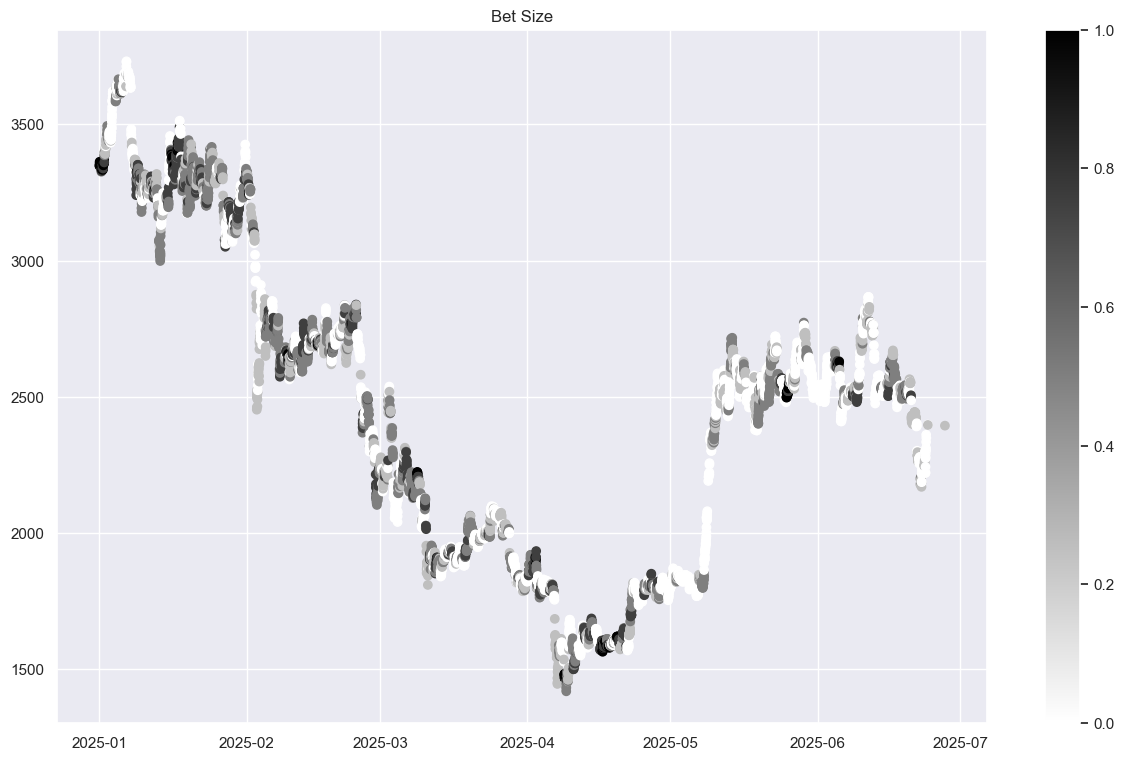

In [90]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= m, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Size')
plt.savefig('image/betsize.jpg')
plt.show()

## Results

### Backtest with zipline/pyfolio

We are not ready for the portfolio optimization.

Here, let us say there are only two assets (ETH and cash)

In [91]:
barrier_t = barrier.loc[y_true2.index]

In [92]:
initial_money=1
bet_size = m*initial_money

In [93]:
wallet = tb.get_wallet_v2(close,barrier_t,initial_money, bet_size, fee_rate=0.0005, slippage=0.0001)
wallet

money_spent  buy_units  money_receive  sell_units  \
open_time                                                                
2024-01-01 00:00:00          0.0        0.0            0.0         0.0   
2024-01-01 00:15:00          0.0        0.0            0.0         0.0   
2024-01-01 00:30:00          0.0        0.0            0.0         0.0   
2024-01-01 00:45:00          0.0        0.0            0.0         0.0   
2024-01-01 01:00:00          0.0        0.0            0.0         0.0   
...                          ...        ...            ...         ...   
2025-06-30 22:45:00          0.0        0.0            0.0         0.0   
2025-06-30 23:00:00          0.0        0.0            0.0         0.0   
2025-06-30 23:15:00          0.0        0.0            0.0         0.0   
2025-06-30 23:30:00          0.0        0.0            0.0         0.0   
2025-06-30 23:45:00          0.0        0.0            0.0         0.0   

                     n_stock  cash_inventory    price  total_equity  returns  
open_time                                                                     
2024-01-01 00:00:00      0.0        1.000000  2298.49      1.000000      0.0  
2024-01-01 00:15:00      0.0        1.000000  2292.83      1.000000      0.0  
2024-01-01 00:30:00      0.0        1.000000  2295.19      1.000000      0.0  
2024-01-01 00:45:00      0.0        1.000000  2297.41      1.000000      0.0  
2024-01-01 01:00:00      0.0        1.000000  2298.53      1.000000      0.0  
...                      ...             ...      ...           ...      ...  
2025-06-30 22:45:00      0.0   -18322.922481  2489.18 -18322.922481      0.0  
2025-06-30 23:00:00      0.0   -18322.922481  2492.06 -18322.922481      0.0  
2025-06-30 23:15:00      0.0   -18322.922481  2489.30 -18322.922481      0.0  
2025-06-30 23:30:00      0.0   -18322.922481  2488.97 -18322.922481      0.0  
2025-06-30 23:45:00      0.0   -18322.922481  2484.30 -18322.922481      0.0  

[52512 rows x 9 columns]

- I made this function for only stocks. For cryptocurrency your buy amount or sell amount can be float.
- There is still error in bet sizing. This function calculate buy amount as *bet_size* * *initial_cash*. It should be *bet_size* * *cash_inventory*.

In [94]:
eth_position = wallet.money_spent-wallet.money_receive
cash_position = wallet.cash_inventory.diff()

In [95]:
eth_position

open_time
2024-01-01 00:00:00    0.0
2024-01-01 00:15:00    0.0
2024-01-01 00:30:00    0.0
2024-01-01 00:45:00    0.0
2024-01-01 01:00:00    0.0
                      ... 
2025-06-30 22:45:00    0.0
2025-06-30 23:00:00    0.0
2025-06-30 23:15:00    0.0
2025-06-30 23:30:00    0.0
2025-06-30 23:45:00    0.0
Length: 52512, dtype: float64

In [96]:
positions = pd.DataFrame()
positions['ETH'] = eth_position
positions['cash'] = cash_position

In [97]:
positions

ETH  cash
open_time                     
2024-01-01 00:00:00  0.0   NaN
2024-01-01 00:15:00  0.0   0.0
2024-01-01 00:30:00  0.0   0.0
2024-01-01 00:45:00  0.0   0.0
2024-01-01 01:00:00  0.0   0.0
...                  ...   ...
2025-06-30 22:45:00  0.0   0.0
2025-06-30 23:00:00  0.0   0.0
2025-06-30 23:15:00  0.0   0.0
2025-06-30 23:30:00  0.0   0.0
2025-06-30 23:45:00  0.0   0.0

[52512 rows x 2 columns]

In [98]:
ret = barrier_t.ret
ret

open_time
2025-01-01 00:00:00    0.051600
2025-01-01 00:15:00    0.051236
2025-01-01 00:30:00    0.049225
2025-01-01 00:45:00    0.049658
2025-01-01 01:30:00    0.050278
                         ...   
2025-06-23 21:00:00    0.050063
2025-06-24 03:45:00    0.048888
2025-06-24 04:15:00    0.049297
2025-06-24 04:30:00    0.049272
2025-06-27 18:45:00    0.049420
Name: ret, Length: 8413, dtype: float64

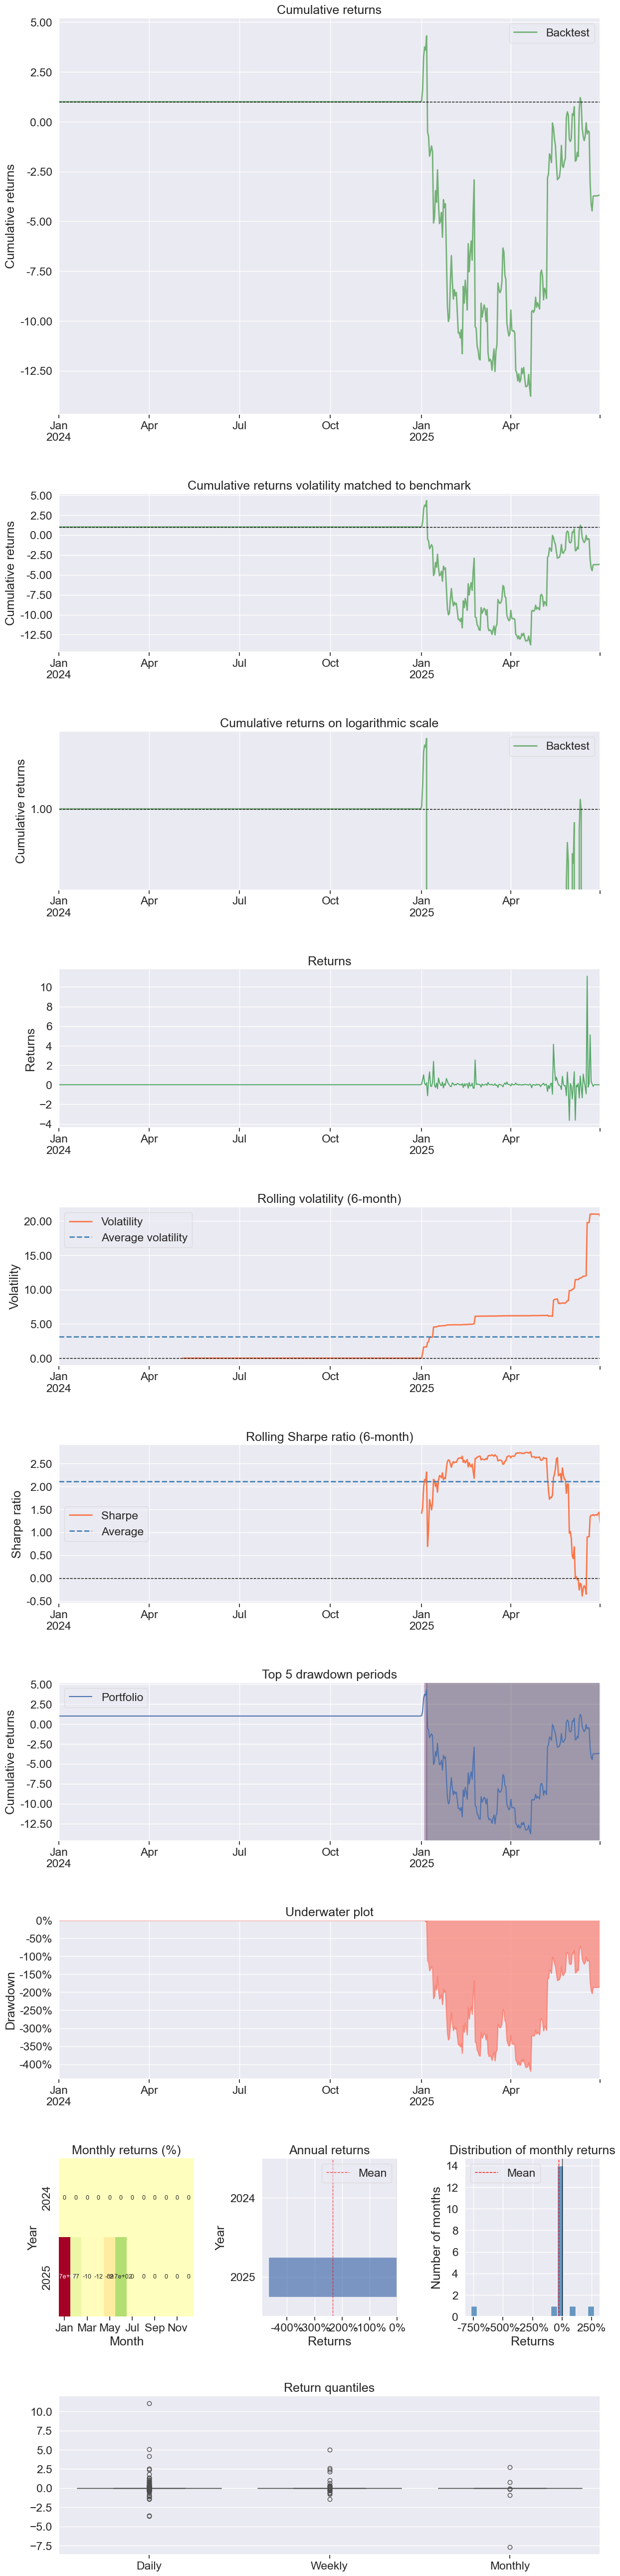

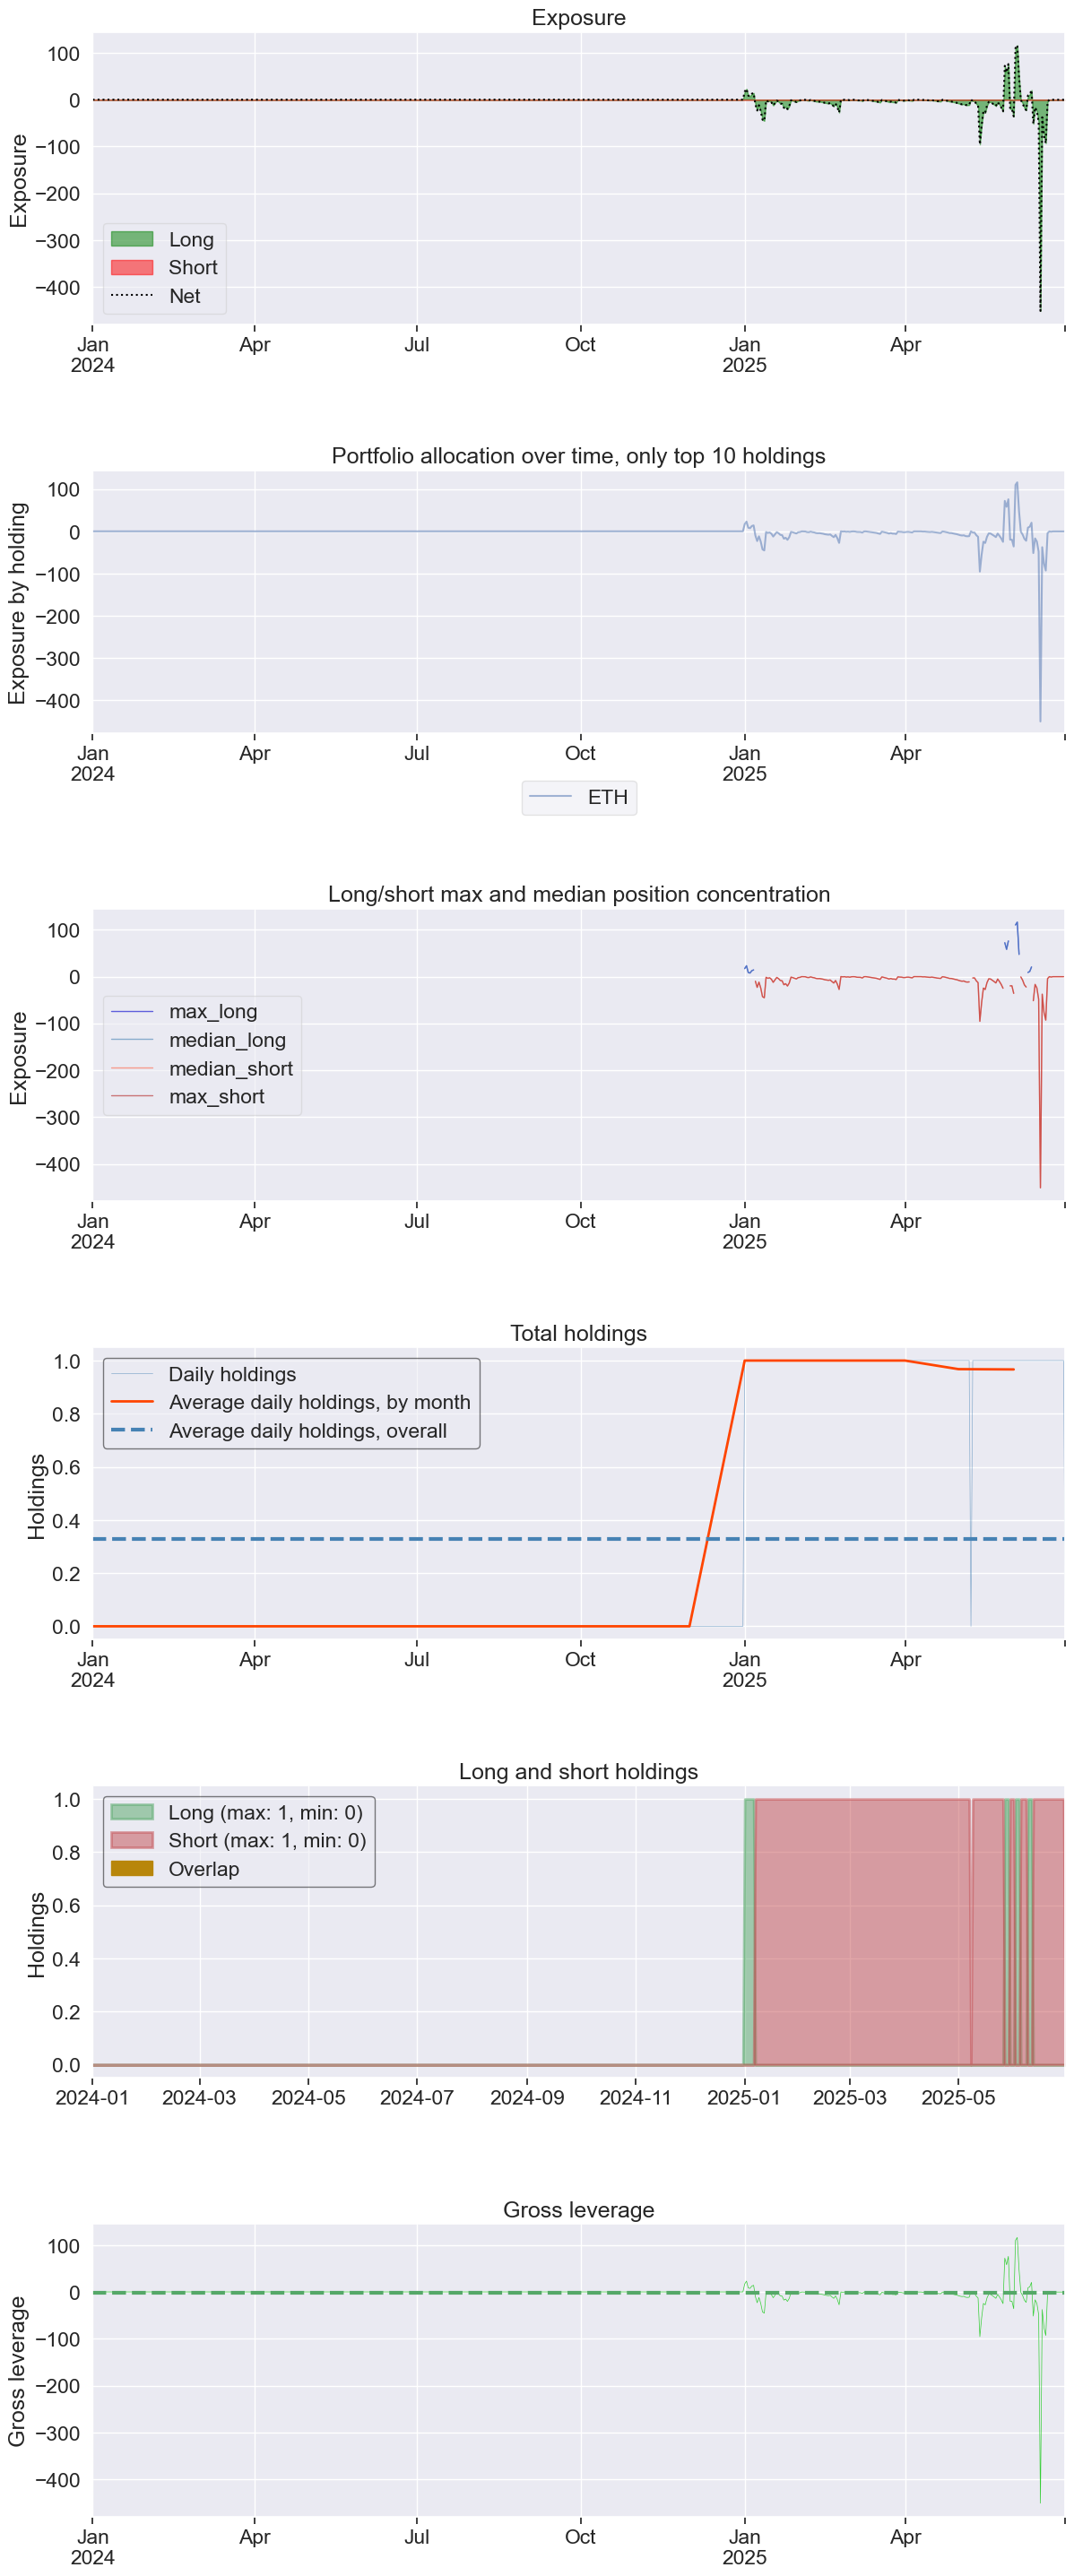

In [109]:
import pyfolio as pf

# 在 Notebook 中这样操作：
wallet = tb.get_wallet_v2(close, barrier_t, initial_money=10000)

# 1. 计算每日收益率 (必须使用复利 prod，不能用 sum)
# wallet['returns'] 已经是小数格式 (0.01 表示 1%)，不要再除以 100
daily_ret = (1 + wallet['returns']).resample('D').prod() - 1

# 2. 准备 Pyfolio 要求的 Positions DataFrame
# 它必须包含各资产市值和 'cash' 列
daily_pos = pd.DataFrame({
    'ETH': wallet['n_stock'] * wallet['price'], # ETH 持仓市值
    'cash': wallet['cash_inventory']            # 现金余额
})

# 3. 持仓重采样：取每日最后时刻的状态 (不能用 sum)
daily_pos_resampled = daily_pos.resample('D').last()

# 4. 调用 Pyfolio
import pyfolio as pf
pf.create_full_tear_sheet(
    returns=daily_ret, 
    positions=daily_pos_resampled
)

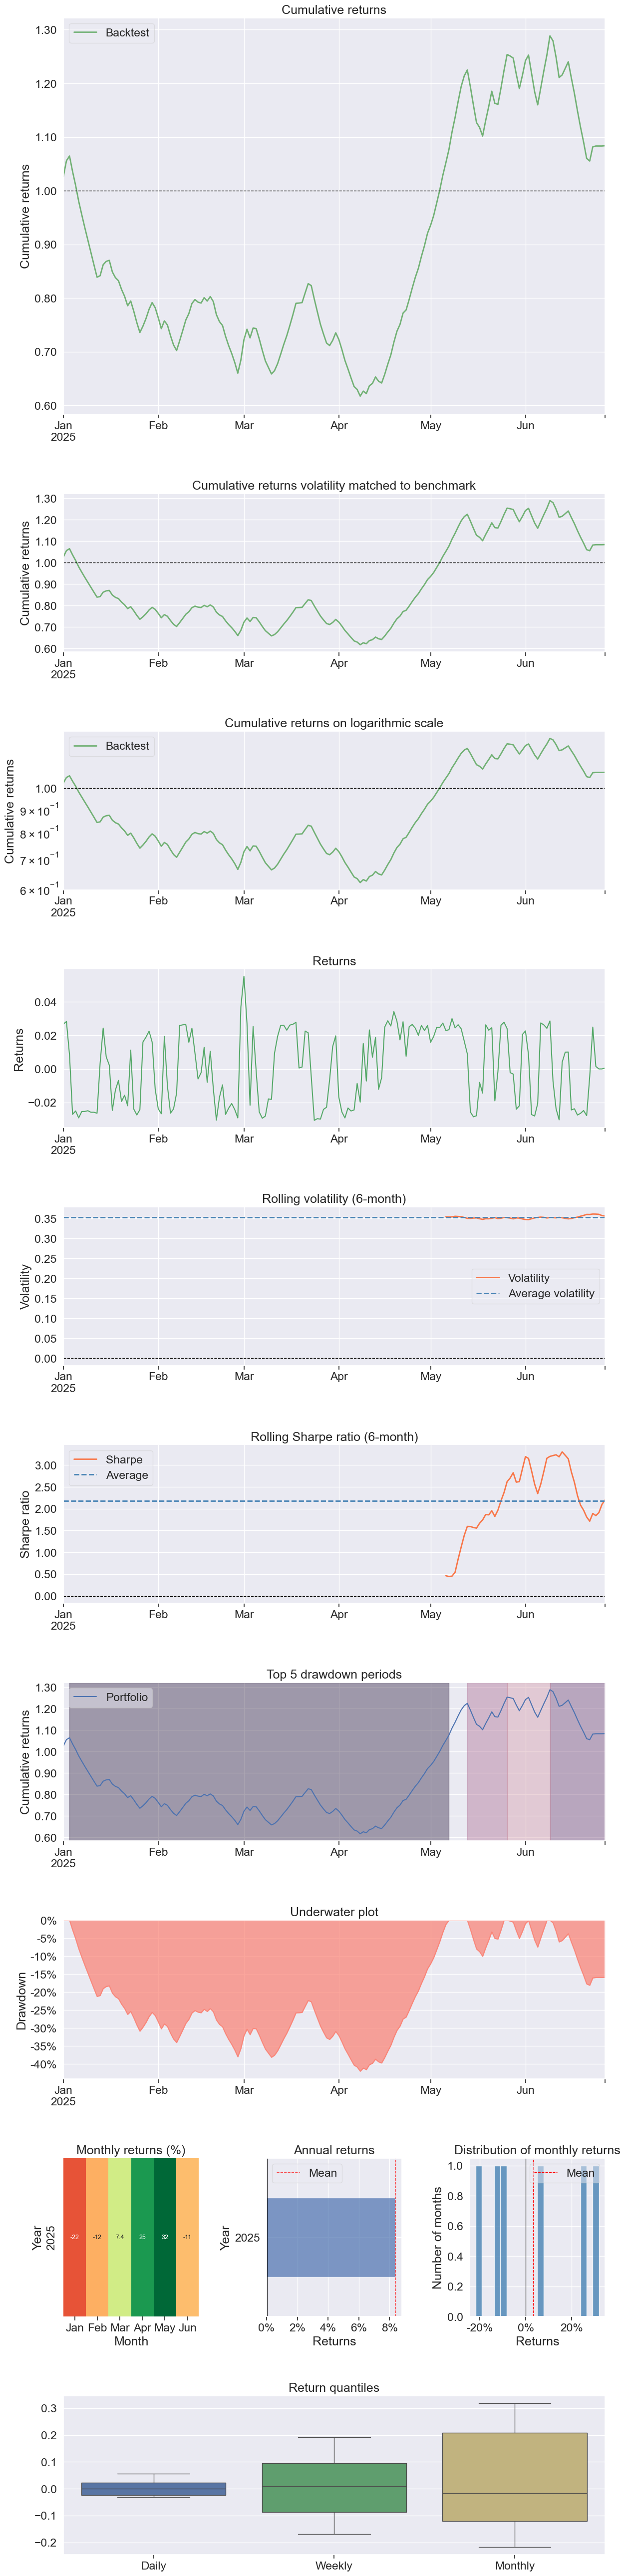

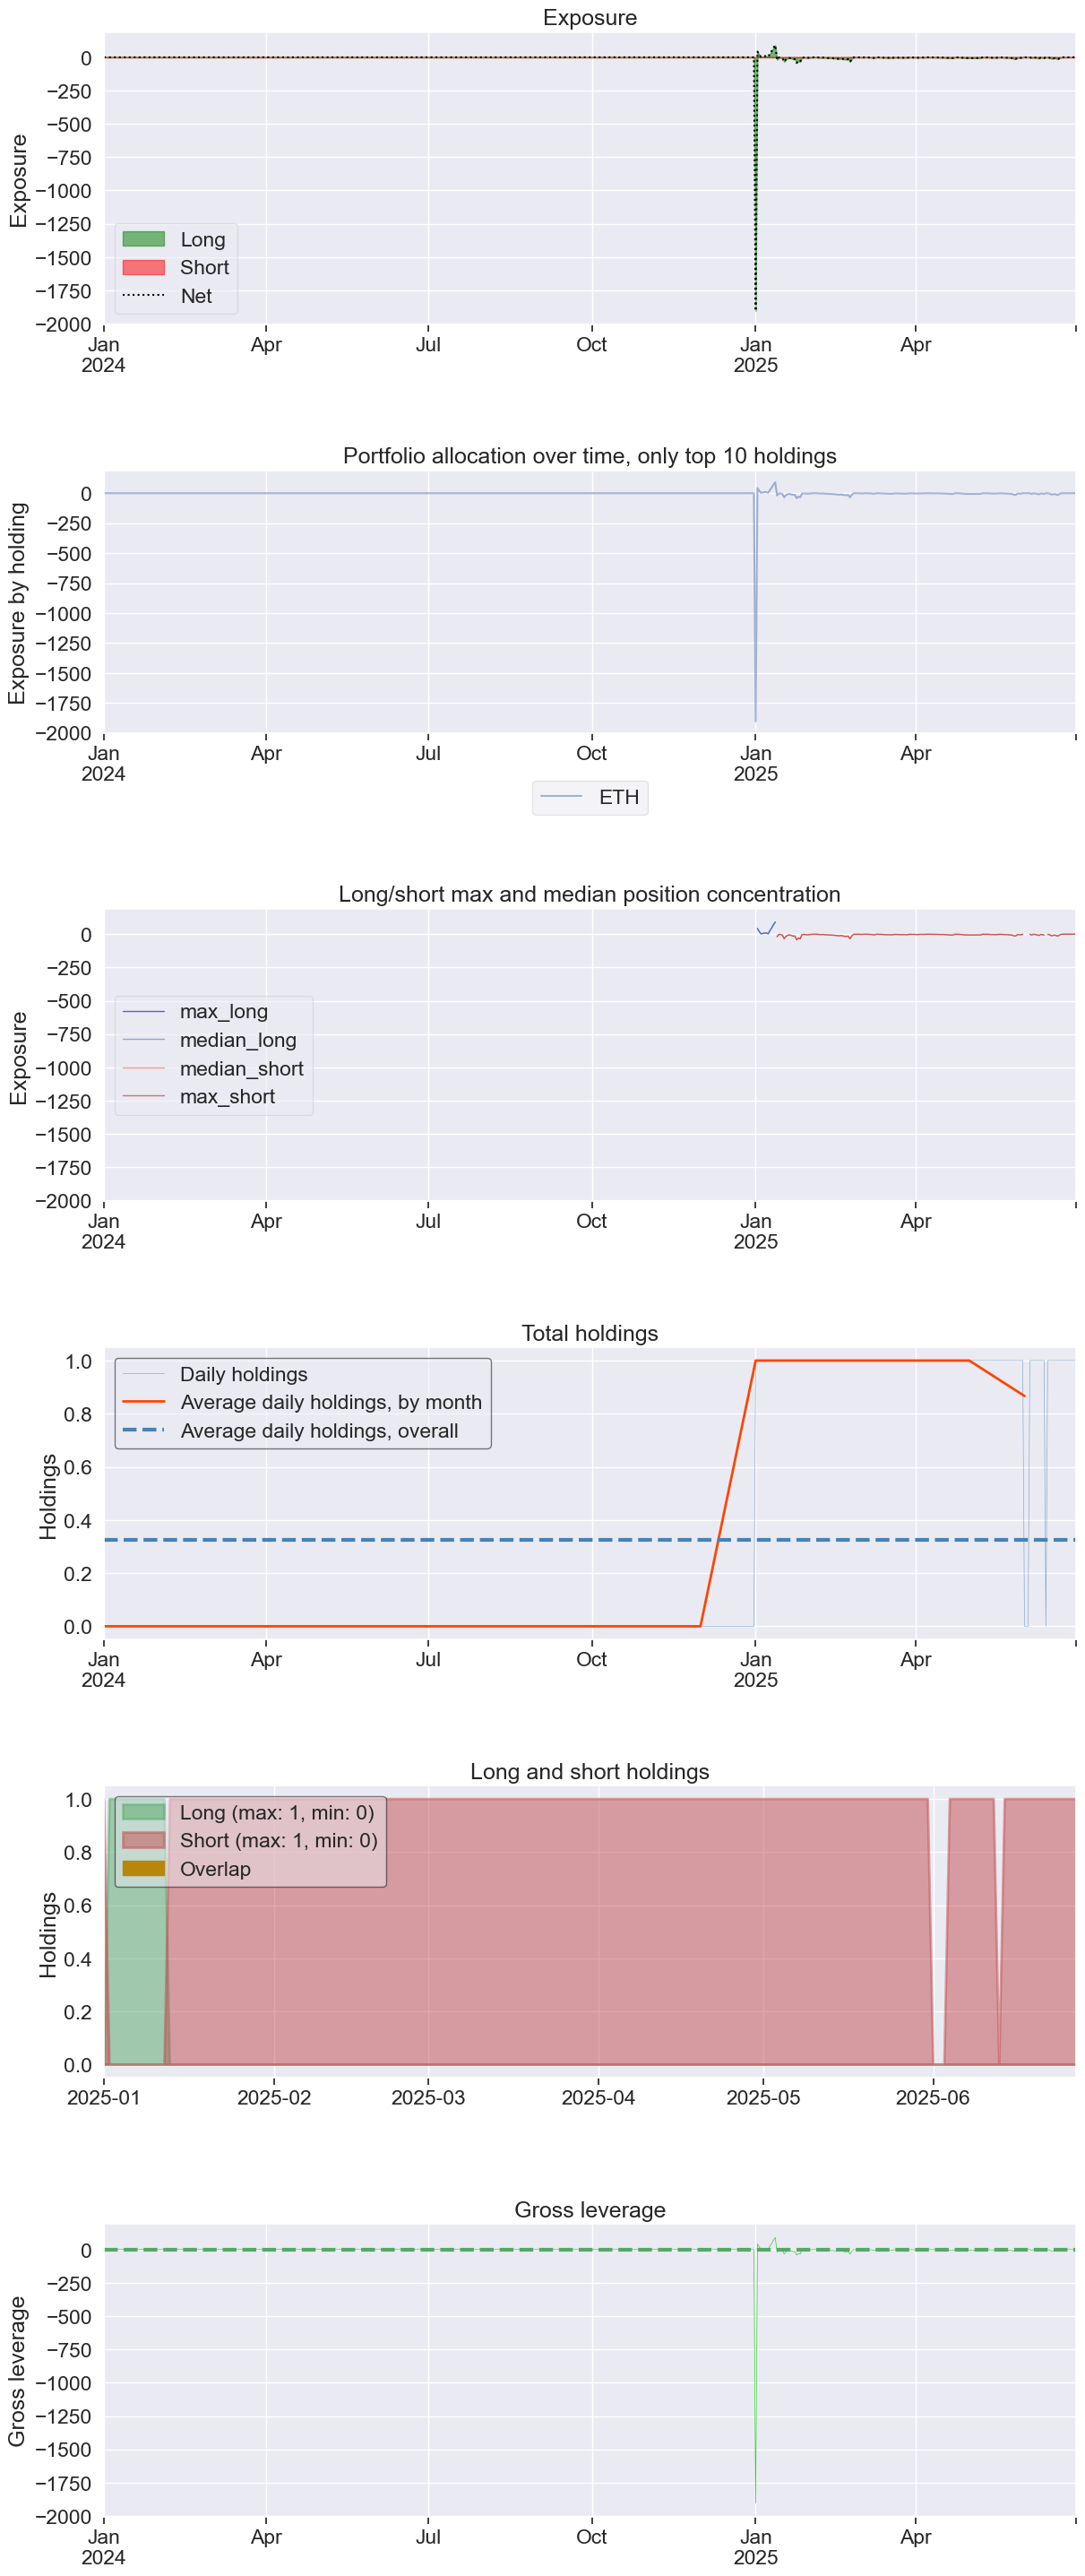

In [106]:
# # 1. 将百分比收益率转换为小数
# ret_daily = ret.resample('D').sum()
# positions_daily = positions.resample('D').sum()

# ret_pyfolio = ret_daily / 100.0

# # 2. 规范化持仓数据 (可选，但建议检查)
# # 确保 positions_daily 的最后一列是 'cash'，且总和代表了组合的总价值
# # 如果您只想看收益率分析，可以暂时不传 positions 参数
# # pf.create_full_tear_sheet(ret_pyfolio) 

# # 3. 正确的调用方式
# import pyfolio as pf

# pf.create_full_tear_sheet(
#     returns=ret_pyfolio, 
#     positions=positions_daily # 确保这里的单位与组合总价值一致
#     # periods_per_year=365       # 针对加密货币市场
# )

# Further Study

Feature Analysis: 
    - How to efficiently extract information from various market features using deep learning.